# 📊 Caderno de Análises — EDA Completa (Planos de Saúde)
**Objetivo:** executar uma EDA padronizada com foco em custos e risco.

**Inclui:** heatmap de ausentes corrigido, matrizes de correlação (geral, risk_score, is_high_risk), pizzas para binárias, gráficos originais e tabelas multivariáveis.


## 0) Ambiente e requisitos
- Python 3.10+
- `pandas`, `numpy`, `seaborn`, `matplotlib`

Se necessário:
```bash
pip install pandas numpy seaborn matplotlib
```

In [89]:

# === 1) Configurações gerais ===
from pathlib import Path

CSV_PATH = Path("/Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/data/full_warehouse_merged.csv")
# CSV_PATH = Path("/mnt/data/full_warehouse_merged.csv")

TARGET_CANDIDATES = ["annual_medical_cost", "annual_premium", "monthly_premium"]
MAX_PAIRPLOT_VARS = 8
MAX_SCATTERS = 10
MAX_BOXPLOTS = 12
LOW_CARDINALITY_MAX = 30
SAMPLE_FOR_SCATTER = 8000
SAVE_FIGS = False
FIG_DPI = 110

TOPN_RISK = 15
MAX_PIES_BINARIES = 999
MISSING_TOKENS_STR = {"no_data", "nd", "na", "n/a", "sem_dado", "sem_dados", ""}
MISSING_TOKENS_NUM = {-1, -1.0}


In [90]:
# === 1.1) Limpeza inicial: substituir -1 por NaN e remover outliers ===
import pandas as pd
import numpy as np
from IPython.display import display

print(f"Lendo CSV de entrada: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)
print("Dimensões originais:", df.shape)

# =====================================================
# 1) Substituir DEFINITIVAMENTE -1 → NaN
# =====================================================
MISSING_TOKENS_STR = {"no_data", "nd", "na", "n/a", "sem_dado", "sem_dados", ""}
MISSING_TOKENS_NUM = {-1, -1.0}

df = df.replace(MISSING_TOKENS_NUM.union(MISSING_TOKENS_STR), np.nan)

print("✔ -1, -1.0 e tokens de missing foram convertidos em NaN.")

# =====================================================
# 2) Detectar e remover outliers em TODAS as colunas numéricas
# =====================================================
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
outlier_mask_global = pd.Series(False, index=df.index)
outlier_report = []

for col in num_cols:
    series = df[col].dropna()
    if series.empty:
        continue
    
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0 or np.isnan(iqr):
        continue
    
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    col_mask = (df[col] < lower) | (df[col] > upper)
    qtd = int(col_mask.sum())

    if qtd > 0:
        outlier_report.append({
            "coluna": col,
            "lim_inf": lower,
            "lim_sup": upper,
            "qtd_outliers": qtd,
        })
    
    outlier_mask_global |= col_mask

total_outliers = int(outlier_mask_global.sum())
print(f"\nTotal de linhas com pelo menos 1 outlier nas numéricas: {total_outliers}")

if outlier_report:
    display(pd.DataFrame(outlier_report).sort_values("qtd_outliers", ascending=False))
else:
    print("Nenhum outlier encontrado pelas regras de IQR.")

# Remover as linhas com outliers
df = df.loc[~outlier_mask_global].copy()
print("Dimensões após remoção de outliers:", df.shape)

# =====================================================
# 3) SALVAR DE VOLTA NO MESMO CSV (como você pediu)
# =====================================================
df.to_csv(CSV_PATH, index=False)
print(f"\n✔ CSV atualizado e limpo salvo em: {CSV_PATH}")

display(df.head())


import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

sns.set(style="whitegrid", palette="viridis", font_scale=1.05)


Lendo CSV de entrada: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/data/full_warehouse_merged.csv
Dimensões originais: (37117, 59)
✔ -1, -1.0 e tokens de missing foram convertidos em NaN.

Total de linhas com pelo menos 1 outlier nas numéricas: 14033


coluna     lim_inf      lim_sup  qtd_outliers
9            deductible   -250.0000    1750.0000          7942
12     visits_last_year     -0.5000       3.5000          3302
1        annual_premium      1.8600     879.5400          1582
2       monthly_premium      0.1450      73.3050          1582
4     total_claims_paid  -1756.1700    2926.9500          1464
3      avg_claim_amount   -977.8800    1629.8000          1276
10               income -32650.0000  108550.0000           855
0   annual_medical_cost  -1579.2075    5378.2125           744
5           systolic_bp     77.5000     153.5000           237
6          diastolic_bp     50.5000      94.5000           231
8                 hba1c      4.3300       6.4900           179
7                   ldl     38.5500     200.5500            28
11                  bmi     13.5500      40.3500            19

Dimensões após remoção de outliers: (23084, 59)

✔ CSV atualizado e limpo salvo em: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/data/full_warehouse_merged.csv


person_id  annual_medical_cost  annual_premium  monthly_premium  \
0          2               709.72          278.13            23.18   
1          6              1462.55          350.40            29.20   
2         10              3251.68          595.20            49.60   
4         12               973.63          298.47            24.87   
5         14              1356.25          340.20            28.35   

   claims_count  avg_claim_amount  total_claims_paid  hypertension  diabetes  \
0           1.0            269.00             269.00             0         0   
1           3.0            219.58             658.74             1         0   
2           0.0              0.00               0.00             0         0   
4           1.0            457.25             457.25             0         0   
5           1.0            704.02             704.02             0         0   

   asthma  ...  proc_imaging_count  proc_surgery_count  proc_physio_count  \
0       0  ...                   0                   0                  0   
1       0  ...                   0                   0                  1   
2       0  ...                   0                   0                  0   
4       0  ...                   0                   0                  0   
5       0  ...                   0                   0                  0   

   proc_consult_count  proc_lab_count  had_major_procedure        cost_id  \
0                   0               0                    0  cost_id_61371   
1                   0               0                    0  cost_id_59155   
2                   1               0                    0  cost_id_18007   
4                   0               0                    0  cost_id_51038   
5                   0               0                    0  cost_id_11301   

         policy_id        record_id        visit_id  
0  policy_id_00119  record_id_45363  visit_id_48818  
1  policy_id_00017  record_id_61337  visit_id_35905  
2  policy_id_00008  record_id_42825  visit_id_60074  
4  policy_id_00002  record_id_38016  visit_id_60819  
5  policy_id_00070  record_id_46605  visit_id_65855  

[5 rows x 59 columns]

In [91]:

# === 3) Helpers gerais ===
def tight_title(title, width=80):
    import textwrap as _tw
    return "\n".join(_tw.wrap(title, width=width))

def ensure_figdir():
    out = Path("figs"); out.mkdir(exist_ok=True); return out

def savefig_maybe(name):
    if SAVE_FIGS:
        outdir = ensure_figdir()
        plt.savefig(outdir / f"{name}.png", dpi=FIG_DPI, bbox_inches="tight")

def detect_columns(df: pd.DataFrame):
    n_rows = len(df)
    id_like = []
    for c in df.columns:
        cname = c.lower()
        nunq = df[c].nunique(dropna=False)
        if ("id" in cname) or (df[c].dtype == "object" and nunq >= 0.9 * n_rows):
            id_like.append(c)
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    for c in num_cols:
        if df[c].nunique() <= LOW_CARDINALITY_MAX and c not in id_like:
            if c not in cat_cols:
                cat_cols.append(c)
    num_cols = [c for c in num_cols if c not in id_like]
    cat_cols = [c for c in cat_cols if c not in id_like]
    return id_like, num_cols, cat_cols

def pick_target(df, candidates):
    for c in candidates:
        if c in df.columns and pd.api.types.is_numeric_dtype(df[c]):
            return c
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        return None
    corr = df[num_cols].corr(numeric_only=True).abs().mean().sort_values(ascending=False)
    return corr.index[0]


In [92]:

# === 4) Ausentes (corrigido) e correlações ===
def build_missing_mask(df: pd.DataFrame) -> pd.DataFrame:
    mask = pd.DataFrame(False, index=df.index, columns=df.columns)
    for c in df.columns:
        s = df[c]
        colmask = s.isna()
        if pd.api.types.is_numeric_dtype(s):
            colmask |= s.isin(MISSING_TOKENS_NUM)
        else:
            s_str = s.astype(str).str.strip().str.lower()
            colmask |= s_str.isin(MISSING_TOKENS_STR)
        mask[c] = colmask
    return mask

def plot_missingness(df):
    miss = build_missing_mask(df)
    if len(miss) > 2000:
        miss = miss.sample(2000, random_state=42)
    plt.figure(figsize=(12, 4))
    sns.heatmap(miss[sorted(miss.columns)], cbar=False)
    plt.title("Mapa de Valores Ausentes por Coluna (tratando -1 / 'no_data' como nulos)")
    plt.xlabel("Colunas"); plt.ylabel("Linhas (amostra)")
    savefig_maybe("01_missingness_heatmap_fixed")
    plt.show()

def plot_correlation_heatmap(df, drop_cols=None, title_suffix=""):
    drop_cols = drop_cols or []
    corr = df.drop(columns=drop_cols, errors="ignore").corr(numeric_only=True)
    plt.figure(figsize=(16, 10))
    sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
    plt.title(tight_title(f"Matriz de Correlação entre Variáveis Numéricas {title_suffix}"))
    savefig_maybe(f"02_corr_heatmap_full{title_suffix.replace(' ', '_')}")
    plt.show()
    return corr

def plot_top_corr_with_target(corr, target, topn=15):
    if target not in corr.columns:
        print(f"[aviso] alvo '{target}' não está na matriz de correlação.")
        return []
    s = corr[target].drop(labels=[target], errors="ignore").abs().sort_values(ascending=False)
    top_vars = s.head(topn).index.tolist()
    print("\nTop correlações absolutas com o alvo:", target)
    print(s.head(topn))
    return top_vars


In [93]:

# === 5) Gráficos originais ===
def plot_distributions(df, num_cols):
    for c in num_cols:
        plt.figure(figsize=(8,5))
        sns.histplot(df[c], kde=True, bins=30)
        plt.title(tight_title(f"Distribuição de {c}"))
        plt.xlabel(c)
        savefig_maybe(f"03_dist_{c}")
        plt.show()

def plot_countplots(df, cat_cols, limit_each=40):
    for c in cat_cols:
        if df[c].nunique(dropna=False) > limit_each:
            continue
        plt.figure(figsize=(10,5))
        order = df[c].value_counts(dropna=False).index
        sns.countplot(data=df, x=c, order=order)
        plt.title(tight_title(f"Contagem por {c}"))
        plt.xticks(rotation=45, ha="right")
        savefig_maybe(f"04_count_{c}")
        plt.tight_layout(); plt.show()

def plot_boxplots_cat_target(df, cat_cols, target, max_plots=12, limit_each=40):
    if target is None:
        return
    plotted = 0
    for c in cat_cols:
        if plotted >= max_plots: break
        if df[c].nunique(dropna=False) > limit_each: continue
        plt.figure(figsize=(10,5))
        sns.boxplot(data=df, x=c, y=target)
        plt.title(tight_title(f"{target} por {c}"))
        plt.xticks(rotation=45, ha="right")
        savefig_maybe(f"05_box_{target}_by_{c}")
        plt.tight_layout(); plt.show()
        plotted += 1

def plot_scatter_with_target(df, num_cols, target, max_plots=10, sample_n=8000):
    if target is None or target not in df.columns:
        return
    corr = df[num_cols + [target]].corr(numeric_only=True)[target].drop(target).abs().sort_values(ascending=False)
    top = corr.index.tolist()[:max_plots]
    data = df if len(df) <= sample_n else df.sample(sample_n, random_state=42)
    for c in top:
        plt.figure(figsize=(8,5))
        sns.regplot(data=data, x=c, y=target, scatter_kws=dict(alpha=0.25, s=12), line_kws=dict())
        plt.title(tight_title(f"{target} vs {c} (com linha de tendência)"))
        savefig_maybe(f"06_scatter_{target}_vs_{c}")
        plt.show()

def plot_pairplot_top(df, target, corr, max_vars=8):
    if target is None or target not in df.columns:
        return
    s = corr[target].drop(labels=[target], errors="ignore").abs().sort_values(ascending=False)
    top_vars = [v for v in s.index.tolist() if pd.api.types.is_numeric_dtype(df[v])]
    vars_to_plot = [target] + top_vars[:max_vars-1]
    data = df[vars_to_plot]
    if len(data) > 4000:
        data = data.sample(4000, random_state=42)
    g = sns.pairplot(data, diag_kind="hist", corner=True)
    g.fig.suptitle(tight_title(f"Pairplot: {target} e variáveis mais correlacionadas"), y=1.02)
    savefig_maybe("07_pairplot_top")
    plt.show()


In [94]:

# === 6) Binárias, risk_score, is_high_risk, multivariadas ===
def _normalize_object_series(s: pd.Series) -> pd.Series:
    if s.dtype == "object":
        return s.astype(str).str.strip().str.lower().replace({
            "sim":"sim","não":"nao","não":"nao","yes":"yes","no":"no",
            "y":"y","n":"n","true":"true","false":"false","t":"t","f":"f",
            "1":"1","0":"0"
        })
    return s

def detect_binary_columns(df: pd.DataFrame, exclude=None):
    exclude = set(exclude or [])
    bin_cols = []
    for c in df.columns:
        if c in exclude: 
            continue
        s = _normalize_object_series(df[c])
        nunq = s.dropna().nunique()
        if nunq == 2:
            bin_cols.append(c)
        else:
            if pd.api.types.is_numeric_dtype(df[c]):
                vals = set(pd.Series(df[c].dropna().unique()).tolist())
                if len(vals) == 2:
                    bin_cols.append(c)
    return bin_cols

def plot_pies_for_binary_columns(df: pd.DataFrame, bin_cols, max_pies=999):
    count = 0
    for c in bin_cols:
        if count >= max_pies: break
        vc = _normalize_object_series(df[c]).value_counts(dropna=False)
        if vc.sum() == 0: continue
        plt.figure(figsize=(5.5,5.5))
        plt.pie(vc.values, labels=[str(k) for k in vc.index], autopct="%1.1f%%", startangle=90)
        plt.title(tight_title(f"Distribuição (pizza) - {c}"))
        plt.axis("equal")
        savefig_maybe(f"08_pie_binary_{c}")
        plt.show()
        count += 1

def plot_corr_matrix_anchor(df: pd.DataFrame, anchor_col: str, topn=15, title_prefix="Foco"):
    if anchor_col not in df.columns:
        print(f"[aviso] '{anchor_col}' não existe."); return pd.DataFrame(), []
    work = df.copy()
    if not pd.api.types.is_numeric_dtype(work[anchor_col]):
        work[anchor_col] = pd.to_numeric(work[anchor_col], errors="coerce")
    num_cols = work.select_dtypes(include=[np.number]).columns.tolist()
    if anchor_col not in num_cols:
        print(f"[aviso] '{anchor_col}' não é numérico após coerção."); return pd.DataFrame(), []
    corr = work[num_cols].corr(numeric_only=True)
    s = corr[anchor_col].drop(labels=[anchor_col], errors="ignore").abs().sort_values(ascending=False)
    top_vars = s.head(topn).index.tolist()
    focus_cols = [anchor_col] + top_vars
    plt.figure(figsize=(8, 6))
    sns.heatmap(work[focus_cols].corr(numeric_only=True), cmap="coolwarm", center=0, annot=True, fmt=".2f")
    plt.title(tight_title(f"{title_prefix}: matriz de correlação — '{anchor_col}' + top {topn}"))
    savefig_maybe(f"corr_matrix_{anchor_col}_focus")
    plt.show()
    table = pd.DataFrame({
        "variavel": s.index,
        "correlacao": corr[anchor_col].drop(anchor_col, errors="ignore")[s.index].values,
        "abs_correlacao": s.values
    }).head(topn)
    return table, top_vars

def corr_with_binary_anchor(df: pd.DataFrame, bin_col: str, topn=15):
    if bin_col not in df.columns:
        print(f"[aviso] '{bin_col}' não existe."); return pd.DataFrame()
    work = df.copy()
    s = work[bin_col]
    if not pd.api.types.is_numeric_dtype(s):
        s = _normalize_object_series(s).replace({"true":1,"yes":1,"y":1,"1":1,
                                                 "false":0,"no":0,"n":0,"0":0})
    work[bin_col] = pd.to_numeric(s, errors="coerce")
    num_cols = work.select_dtypes(include=[np.number]).columns.tolist()
    if bin_col not in num_cols:
        print(f"[aviso] '{bin_col}' não pôde ser binarizado."); return pd.DataFrame()
    corrs = work[num_cols].corr(numeric_only=True)[bin_col].drop(labels=[bin_col], errors="ignore")
    table = (pd.DataFrame({"variavel": corrs.index,
                           "correlacao": corrs.values,
                           "abs_correlacao": np.abs(corrs.values)})
             .sort_values("abs_correlacao", ascending=False)
             .head(topn))
    return table

def _first_existing(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def multivar_tables(df: pd.DataFrame,
                    cost_col="annual_medical_cost",
                    risk_col="risk_score"):
    out = {}
    if cost_col not in df.columns or risk_col not in df.columns:
        return out
    risk = pd.to_numeric(df[risk_col], errors="coerce")
    if risk.nunique(dropna=True) >= 10:
        bins = pd.qcut(risk, 10, labels=[f"D{i}" for i in range(1,11)])
    else:
        bins = pd.qcut(risk, 4, labels=[f"Q{i}" for i in range(1,5)])
    df2 = df.copy()
    df2["risk_bin"] = bins

    c_plan   = _first_existing(df2, ["plan_type", "plan", "product"])
    c_tier   = _first_existing(df2, ["network_tier", "network", "tier"])
    c_region = _first_existing(df2, ["region"])
    c_sex    = _first_existing(df2, ["sex", "gender"])

    out["by_risk_bin"] = (df2.groupby("risk_bin", dropna=True)[cost_col]
                             .agg(["count","mean","median","std"]).reset_index())

    if c_plan:
        out["plan_x_risk"] = (df2.pivot_table(index=c_plan, columns="risk_bin",
                                              values=cost_col, aggfunc="mean").reset_index())
    if c_plan and c_tier:
        out["plan_tier_x_risk"] = (df2.pivot_table(index=[c_plan, c_tier], columns="risk_bin",
                                                   values=cost_col, aggfunc="mean").reset_index())
    if c_region:
        out["region_x_risk"] = (df2.pivot_table(index=c_region, columns="risk_bin",
                                                values=cost_col, aggfunc="mean").reset_index())
    if c_sex:
        out["sex_x_risk"] = (df2.pivot_table(index=c_sex, columns="risk_bin",
                                             values=cost_col, aggfunc="mean").reset_index())

    for name, tbl in out.items():
        p = Path(f"table_{name}.csv")
        tbl.to_csv(p, index=False)
        print(f"[ok] salvo: {p.resolve()}")

    return out


In [95]:
def plot_sex_risk_cost_comparisons(df: pd.DataFrame,
                                   sex_col: str = "sex",
                                   risk_col: str = "risk_score",
                                   cost_col: str = "annual_medical_cost"):
    """
    Compara risk_score e annual_medical_cost entre Male, Female e no_data.

    Gera:
    - Boxplots (risk e cost)
    - Violinplots (risk e cost)
    - Barras (média + IC) para risk e cost
    - 'Dashboard' com barras lado a lado (risk x cost)
    """
    missing_cols = [c for c in [sex_col, risk_col, cost_col] if c not in df.columns]
    if missing_cols:
        print(f"[aviso] colunas ausentes no df: {missing_cols}")
        return

    # Mantém os 3 grupos como estão: Male, Female, no_data
    data = df[[sex_col, risk_col, cost_col]].copy()

    # --- BOXPlots ---

    # Boxplot risk_score x sex
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=data, x=sex_col, y=risk_col)
    plt.title(tight_title(f"{risk_col} por {sex_col} (boxplot)"))
    plt.xlabel(sex_col); plt.ylabel(risk_col)
    savefig_maybe("sex_boxplot_risk_score")
    plt.tight_layout(); plt.show()

    # Boxplot annual_medical_cost x sex
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=data, x=sex_col, y=cost_col)
    plt.title(tight_title(f"{cost_col} por {sex_col} (boxplot)"))
    plt.xlabel(sex_col); plt.ylabel(cost_col)
    savefig_maybe("sex_boxplot_annual_medical_cost")
    plt.tight_layout(); plt.show()

    # --- VIOLINPlots ---

    # Violin risk_score x sex
    plt.figure(figsize=(8, 5))
    sns.violinplot(data=data, x=sex_col, y=risk_col, cut=0, inner="quart")
    plt.title(tight_title(f"{risk_col} por {sex_col} (violinplot)"))
    plt.xlabel(sex_col); plt.ylabel(risk_col)
    savefig_maybe("sex_violin_risk_score")
    plt.tight_layout(); plt.show()

    # Violin annual_medical_cost x sex
    plt.figure(figsize=(8, 5))
    sns.violinplot(data=data, x=sex_col, y=cost_col, cut=0, inner="quart")
    plt.title(tight_title(f"{cost_col} por {sex_col} (violinplot)"))
    plt.xlabel(sex_col); plt.ylabel(cost_col)
    savefig_maybe("sex_violin_annual_medical_cost")
    plt.tight_layout(); plt.show()

    # --- Barras com média + IC (seaborn já traz IC por padrão) ---

    # Barplot risk_score x sex
    plt.figure(figsize=(8, 5))
    sns.barplot(data=data, x=sex_col, y=risk_col, errorbar="ci", estimator=np.mean)
    plt.title(tight_title(f"Média de {risk_col} por {sex_col} (barra + IC)"))
    plt.xlabel(sex_col); plt.ylabel(f"média de {risk_col}")
    savefig_maybe("sex_bar_mean_risk_score")
    plt.tight_layout(); plt.show()

    # Barplot annual_medical_cost x sex
    plt.figure(figsize=(8, 5))
    sns.barplot(data=data, x=sex_col, y=cost_col, errorbar="ci", estimator=np.mean)
    plt.title(tight_title(f"Média de {cost_col} por {sex_col} (barra + IC)"))
    plt.xlabel(sex_col); plt.ylabel(f"média de {cost_col}")
    savefig_maybe("sex_bar_mean_annual_medical_cost")
    plt.tight_layout(); plt.show()

    # --- Dashboard: duas barras lado a lado (risk x cost) ---

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

    sns.barplot(data=data, x=sex_col, y=risk_col, errorbar="ci", estimator=np.mean, ax=axes[0])
    axes[0].set_title(tight_title(f"Média de {risk_col} por {sex_col}"))
    axes[0].set_xlabel(sex_col); axes[0].set_ylabel(risk_col)

    sns.barplot(data=data, x=sex_col, y=cost_col, errorbar="ci", estimator=np.mean, ax=axes[1])
    axes[1].set_title(tight_title(f"Média de {cost_col} por {sex_col}"))
    axes[1].set_xlabel(sex_col); axes[1].set_ylabel(cost_col)

    fig.suptitle(tight_title(f"Comparação por {sex_col}: {risk_col} x {cost_col} (médias + IC)"), y=1.03)
    plt.tight_layout()
    savefig_maybe("sex_dashboard_risk_cost_bar_means")
    plt.show()


In [96]:

# === 7) Carrega dados e pré-visualiza ===
print(f"Lendo: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)
print("Formato:", df.shape)
df.head()


Lendo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/data/full_warehouse_merged.csv
Formato: (23084, 59)


person_id  annual_medical_cost  annual_premium  monthly_premium  \
0          2               709.72          278.13            23.18   
1          6              1462.55          350.40            29.20   
2         10              3251.68          595.20            49.60   
3         12               973.63          298.47            24.87   
4         14              1356.25          340.20            28.35   

   claims_count  avg_claim_amount  total_claims_paid  hypertension  diabetes  \
0           1.0            269.00             269.00             0         0   
1           3.0            219.58             658.74             1         0   
2           0.0              0.00               0.00             0         0   
3           1.0            457.25             457.25             0         0   
4           1.0            704.02             704.02             0         0   

   asthma  ...  proc_imaging_count  proc_surgery_count  proc_physio_count  \
0       0  ...                   0                   0                  0   
1       0  ...                   0                   0                  1   
2       0  ...                   0                   0                  0   
3       0  ...                   0                   0                  0   
4       0  ...                   0                   0                  0   

   proc_consult_count  proc_lab_count  had_major_procedure        cost_id  \
0                   0               0                    0  cost_id_61371   
1                   0               0                    0  cost_id_59155   
2                   1               0                    0  cost_id_18007   
3                   0               0                    0  cost_id_51038   
4                   0               0                    0  cost_id_11301   

         policy_id        record_id        visit_id  
0  policy_id_00119  record_id_45363  visit_id_48818  
1  policy_id_00017  record_id_61337  visit_id_35905  
2  policy_id_00008  record_id_42825  visit_id_60074  
3  policy_id_00002  record_id_38016  visit_id_60819  
4  policy_id_00070  record_id_46605  visit_id_65855  

[5 rows x 59 columns]

In [97]:

# === 8) Detecta colunas e variáveis binárias ===
id_like, num_cols, cat_cols = detect_columns(df)
print("\nColunas ID-like:", id_like[:20], "..." if len(id_like) > 20 else "")
print("Numéricas:", num_cols[:10], "..." if len(num_cols) > 10 else "")
print("Categóricas:", cat_cols[:10], "..." if len(cat_cols) > 10 else "")
bin_cols = detect_binary_columns(df, exclude=id_like)
print("Binárias detectadas:", bin_cols[:30], "..." if len(bin_cols) > 30 else "")



Colunas ID-like: ['person_id', 'total_claims_paid', 'kidney_disease', 'provider_quality', 'cost_id', 'policy_id', 'record_id', 'visit_id'] 
Numéricas: ['annual_medical_cost', 'annual_premium', 'monthly_premium', 'claims_count', 'avg_claim_amount', 'hypertension', 'diabetes', 'asthma', 'copd', 'cardiovascular_disease'] ...
Categóricas: ['plan_type', 'network_tier', 'sex', 'region', 'urban_rural', 'education', 'marital_status', 'employment_status', 'smoker', 'alcohol_freq'] ...
Binárias detectadas: ['hypertension', 'diabetes', 'asthma', 'copd', 'cardiovascular_disease', 'cancer_history', 'liver_disease', 'arthritis', 'mental_health', 'is_high_risk', 'deductible', 'had_major_procedure'] 


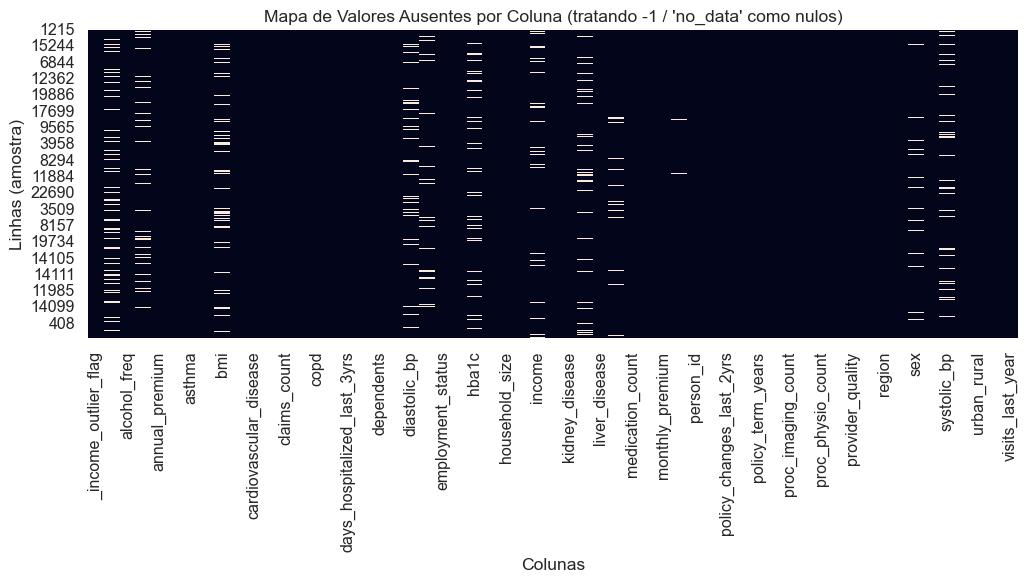

In [98]:

# === 9) Heatmap de ausentes (corrigido) ===
plot_missingness(df)


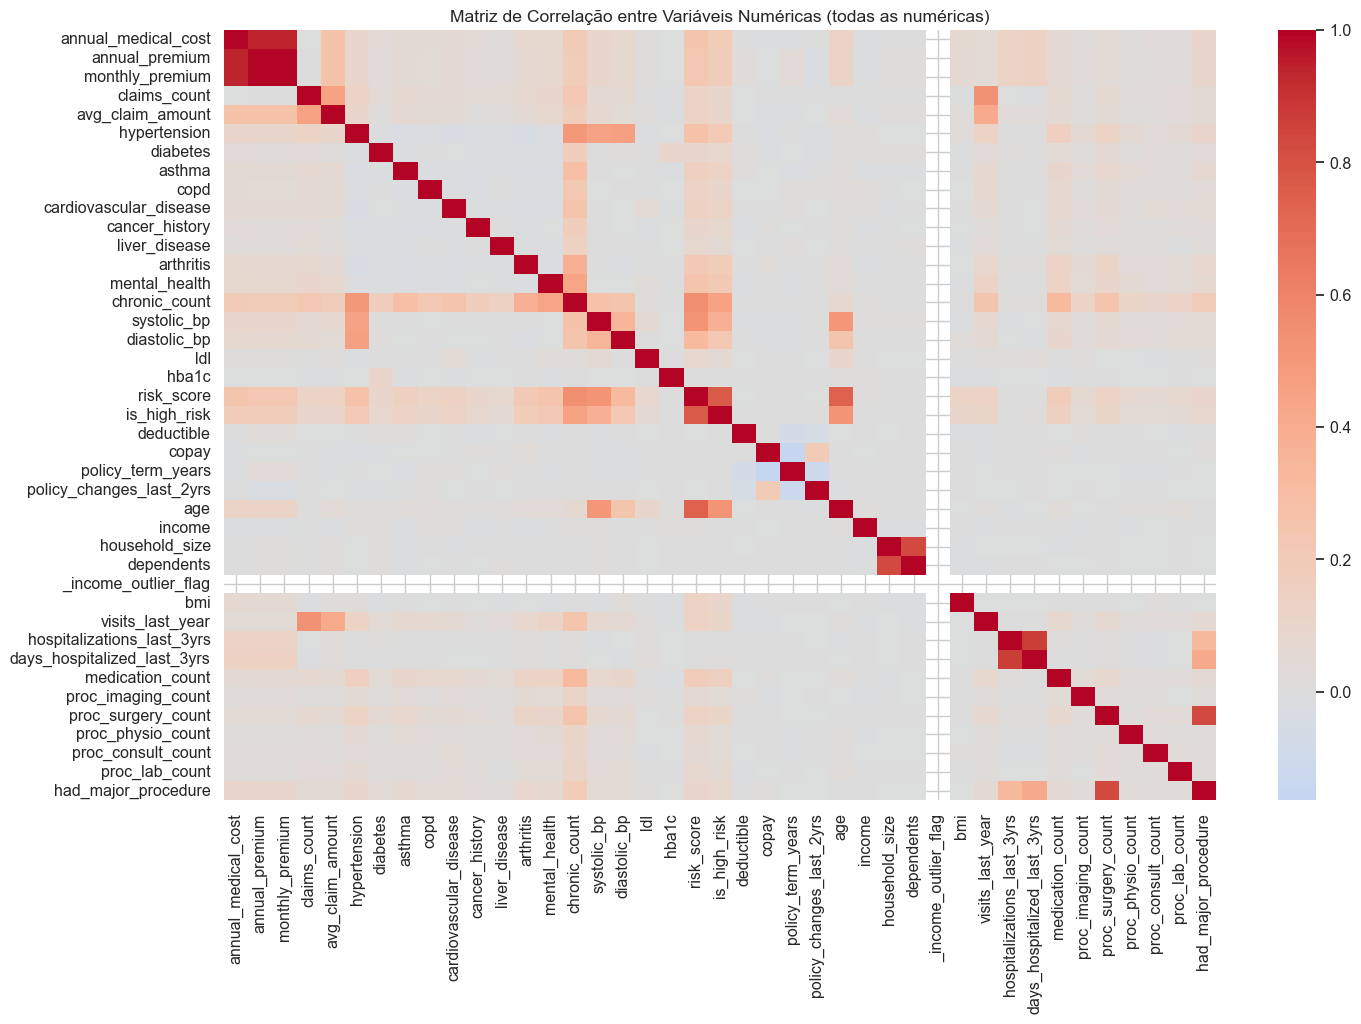

In [99]:

# === 10) Matriz de correlação (todas numéricas) ===
corr_full = plot_correlation_heatmap(df, drop_cols=id_like, title_suffix="(todas as numéricas)")


Alvo selecionado: annual_medical_cost

Top correlações absolutas com o alvo: annual_medical_cost
annual_premium                 0.937451
monthly_premium                0.937451
avg_claim_amount               0.265444
risk_score                     0.240814
chronic_count                  0.197980
is_high_risk                   0.186277
days_hospitalized_last_3yrs    0.148584
hospitalizations_last_3yrs     0.135497
age                            0.119432
systolic_bp                    0.101753
hypertension                   0.099960
had_major_procedure            0.095759
mental_health                  0.080586
diastolic_bp                   0.077792
arthritis                      0.076206
Name: annual_medical_cost, dtype: float64


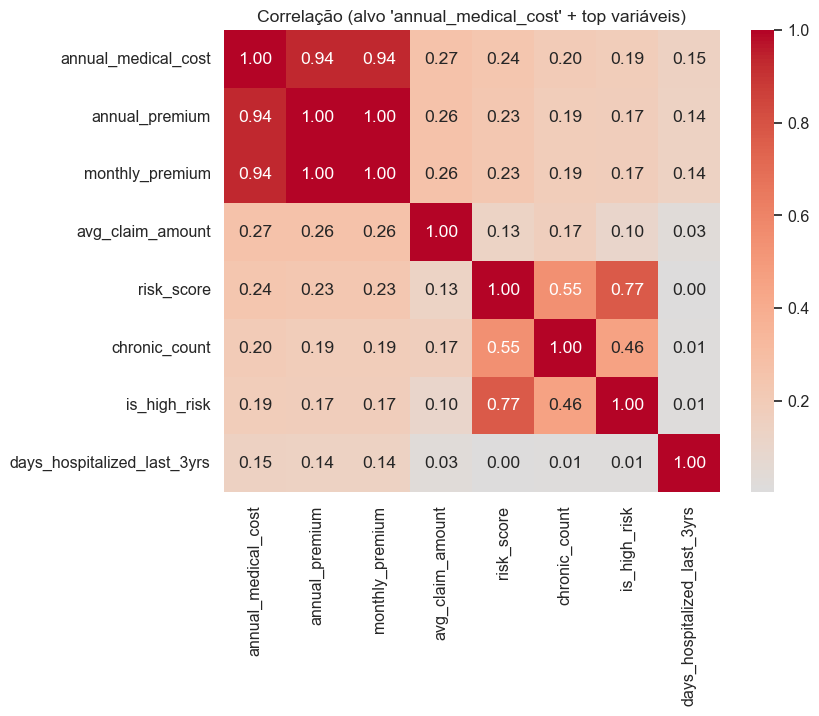

In [100]:

# === 11) Alvo escolhido + heatmap focado ===
target = pick_target(df, TARGET_CANDIDATES)
print(f"Alvo selecionado: {target}")
if target:
    top_vars = plot_top_corr_with_target(corr_full, target, topn=15)
    focus_cols = [target] + top_vars[:MAX_PAIRPLOT_VARS-1]
    focus_corr = df[focus_cols].corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    sns.heatmap(focus_corr, cmap="coolwarm", center=0, annot=True, fmt=".2f")
    plt.title(tight_title(f"Correlação (alvo '{target}' + top variáveis)"))
    savefig_maybe("02b_corr_heatmap_target_focus")
    plt.show()


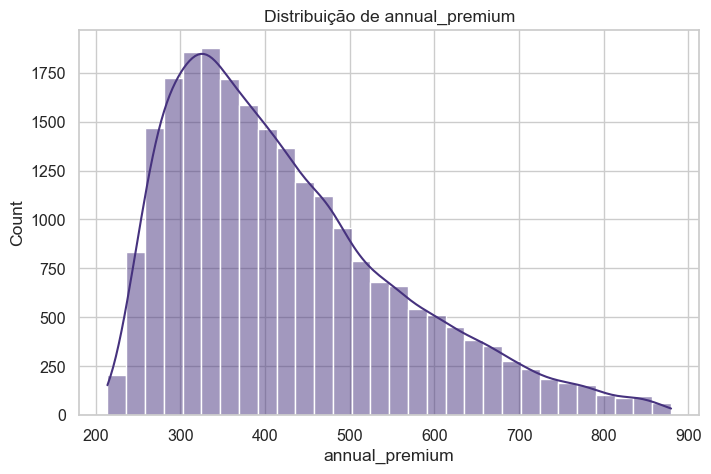

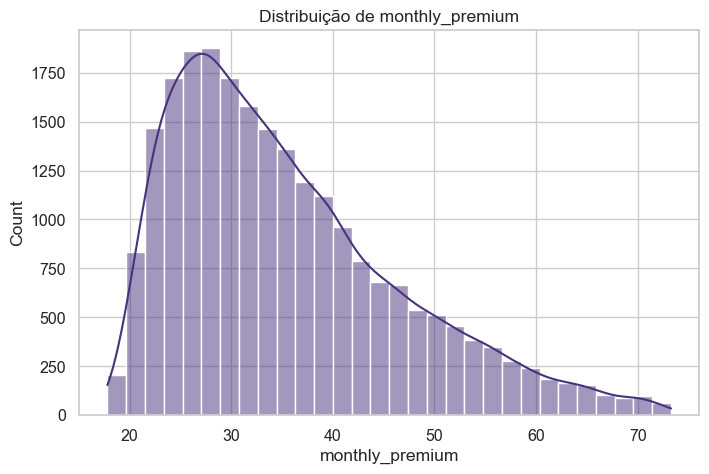

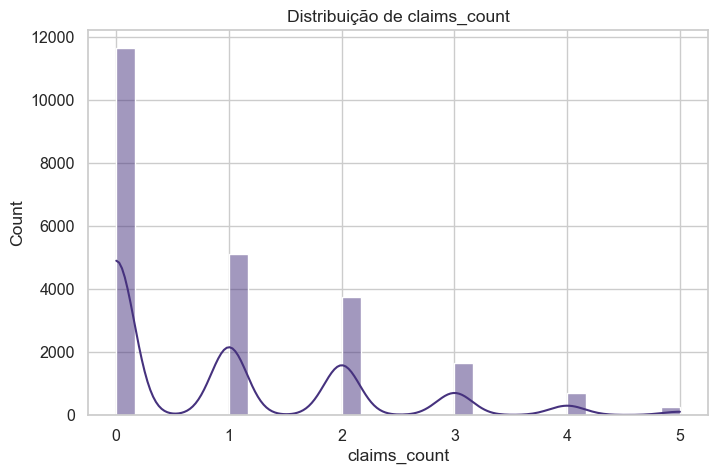

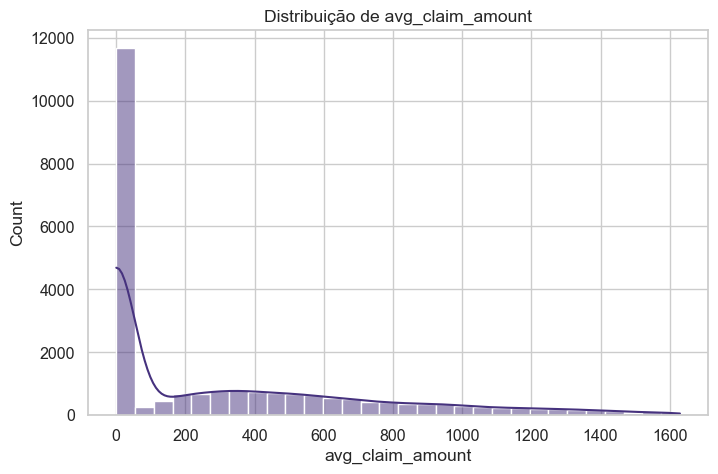

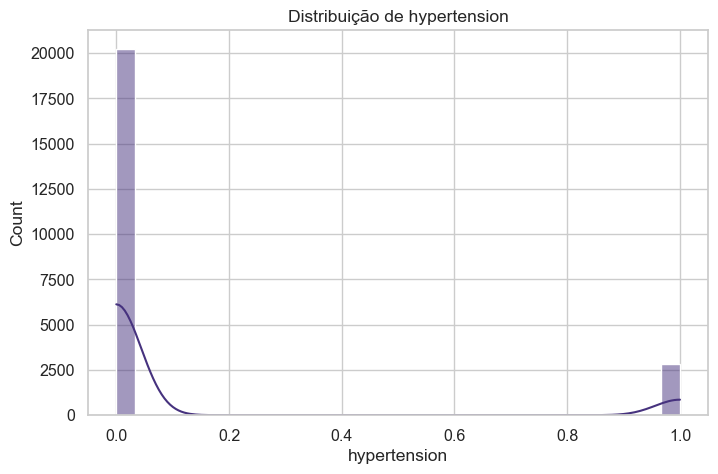

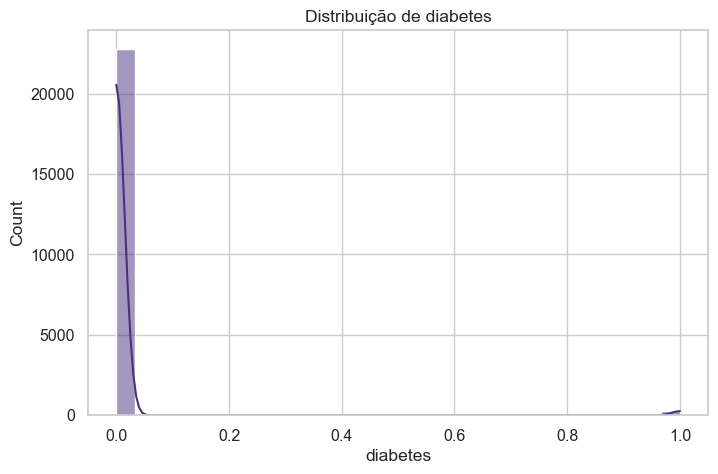

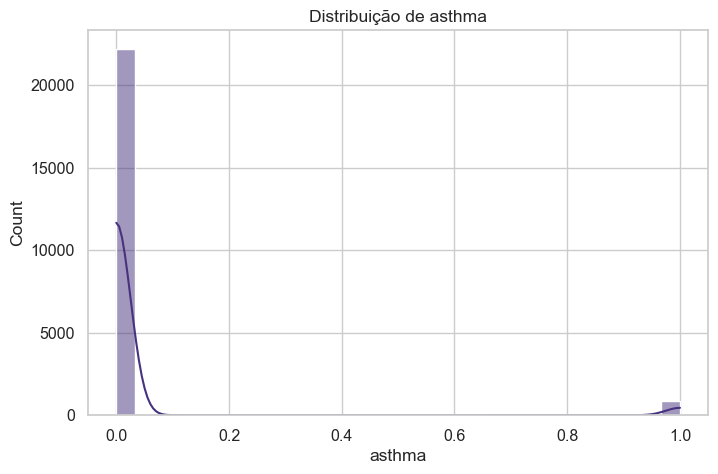

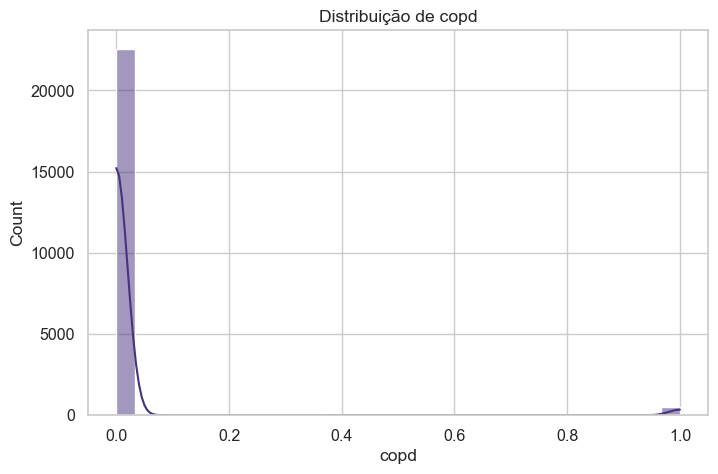

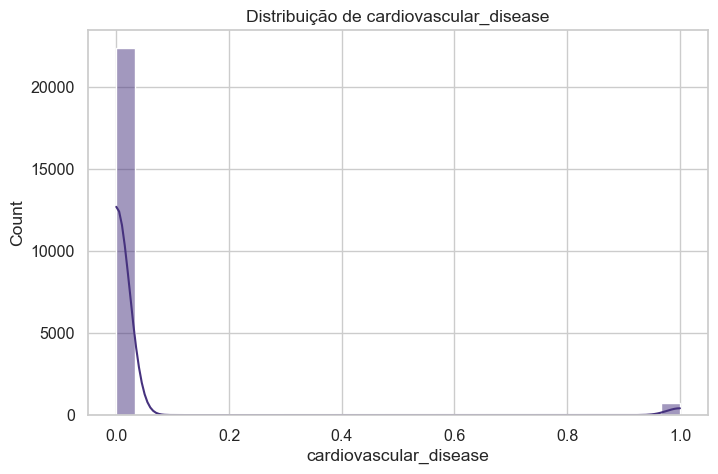

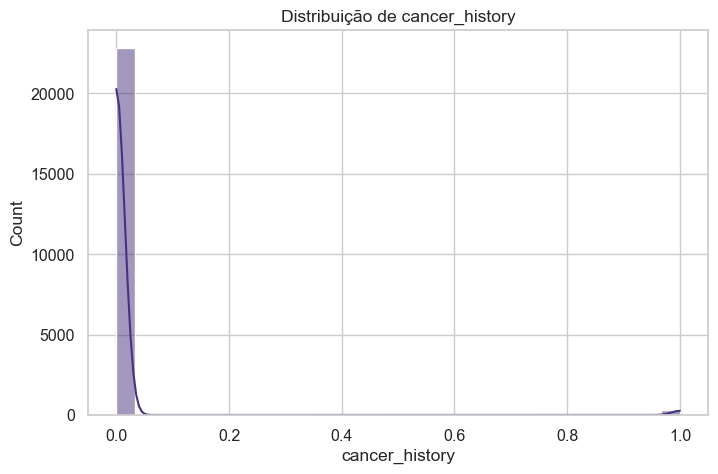

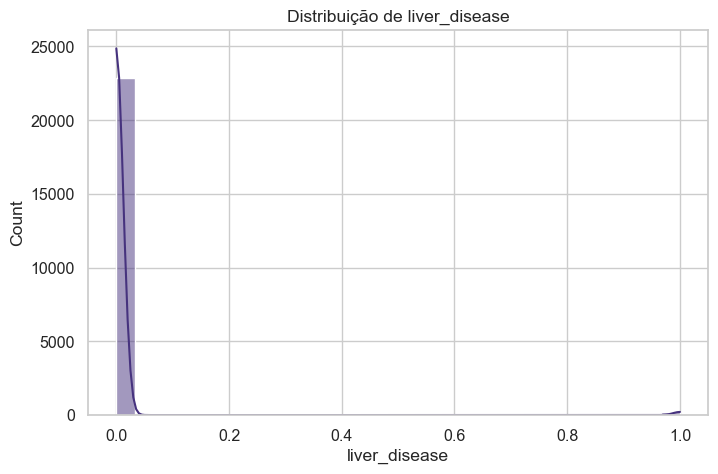

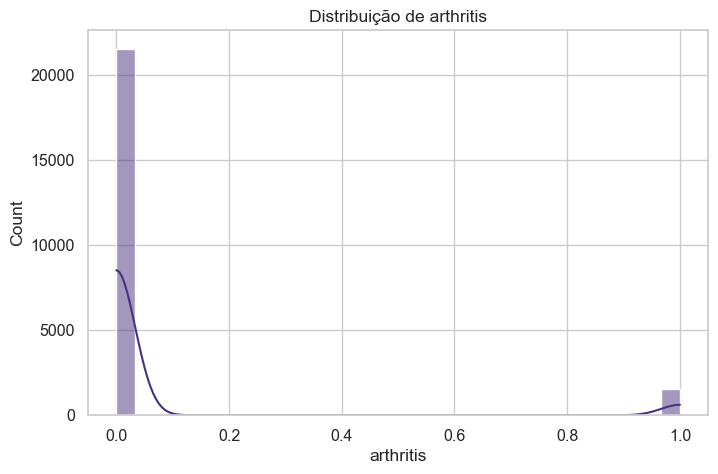

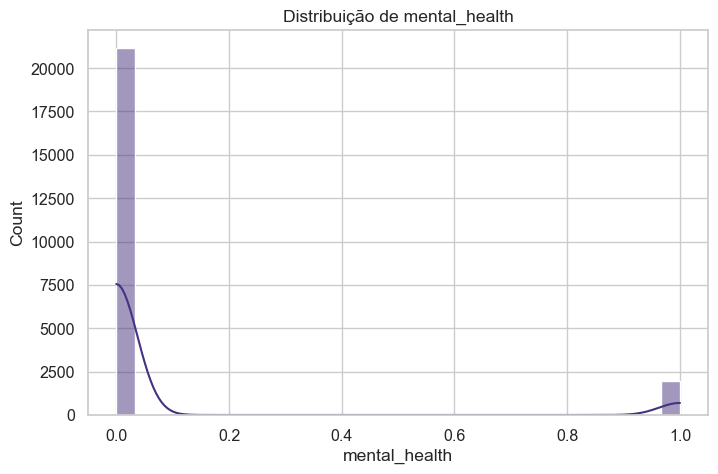

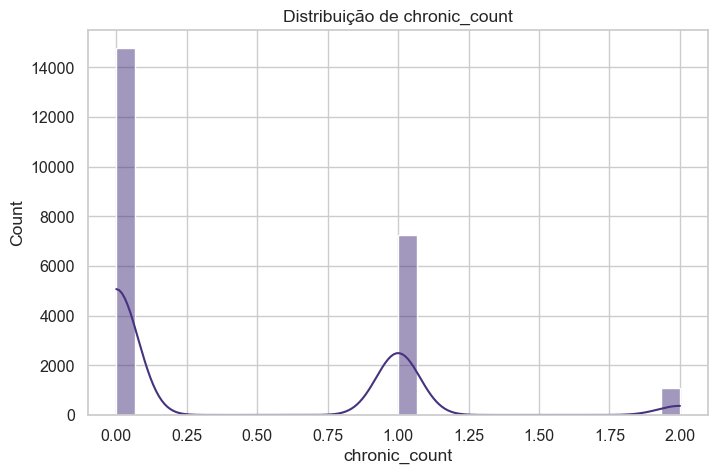

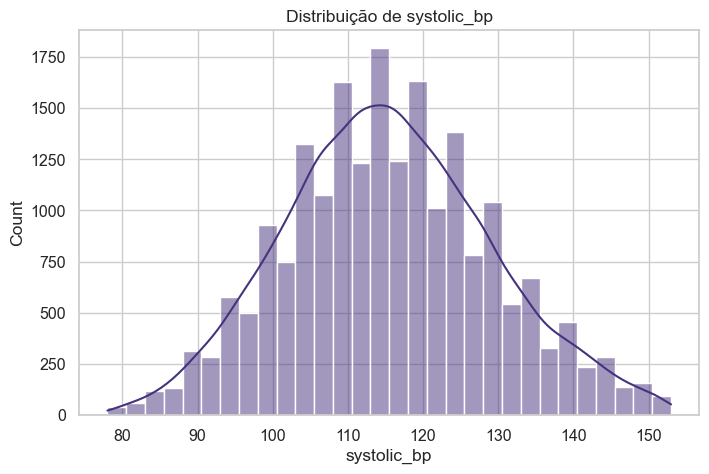

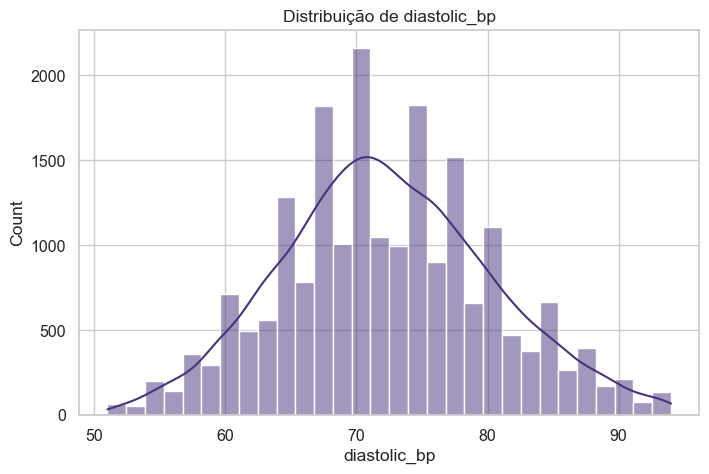

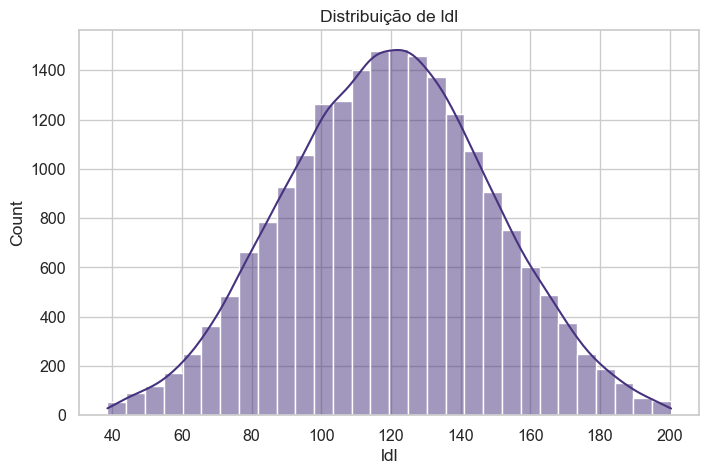

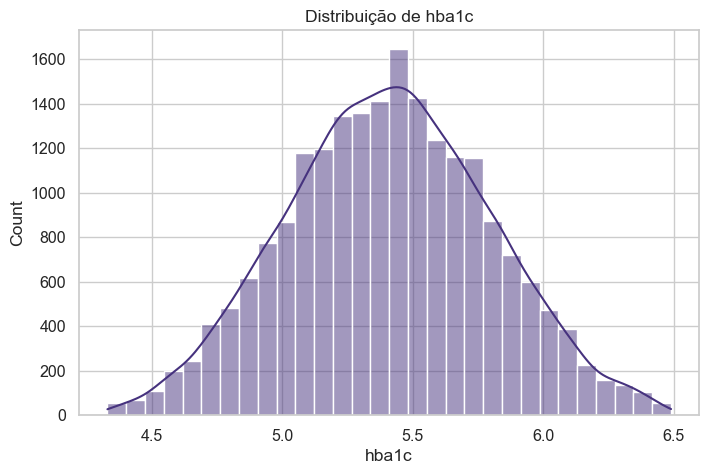

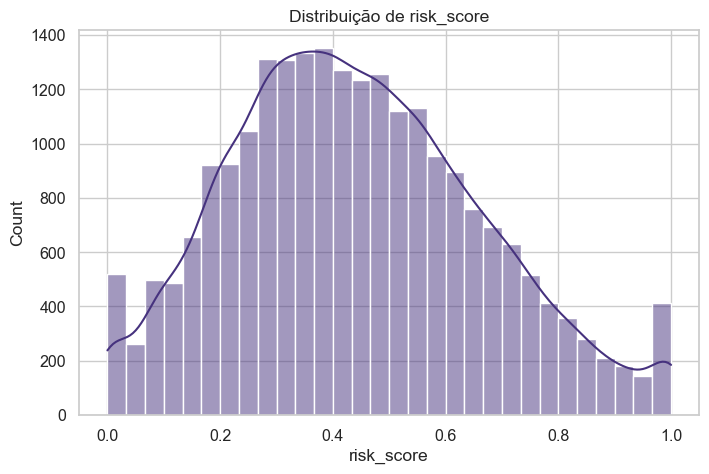

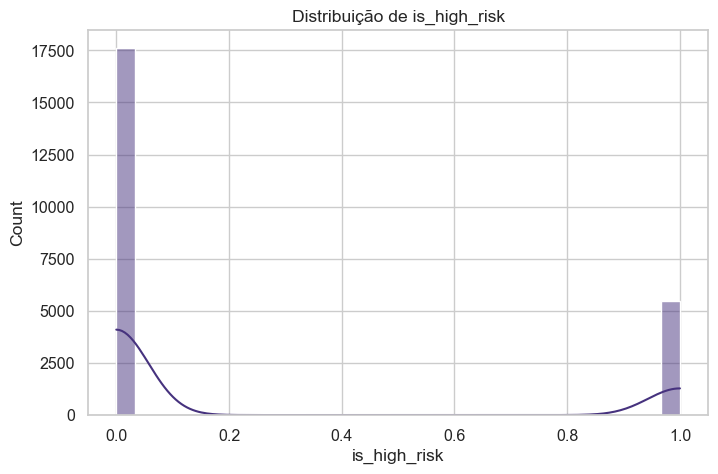

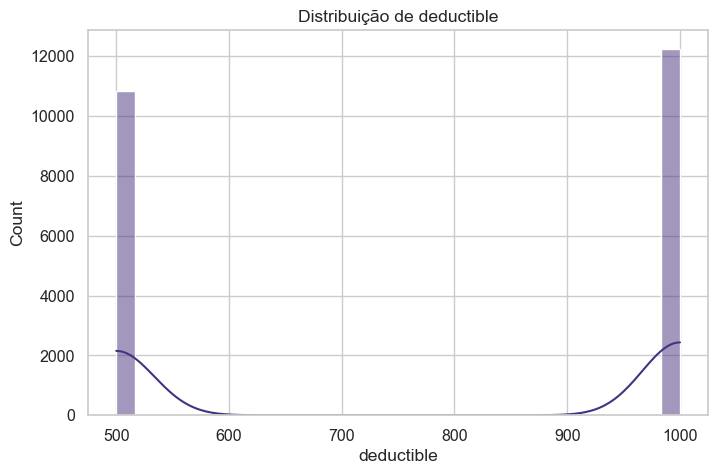

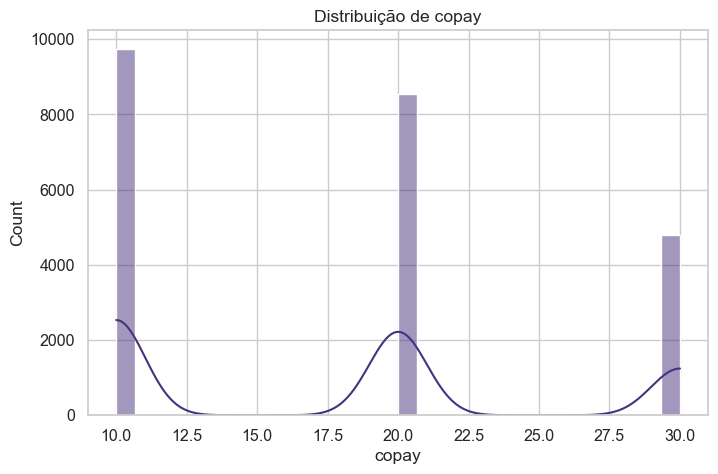

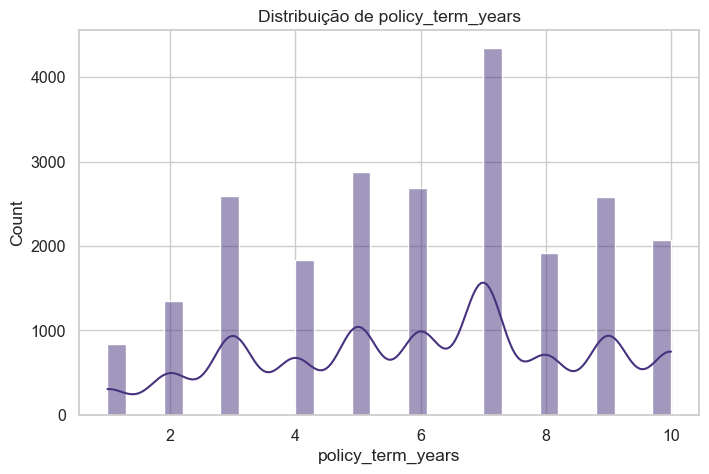

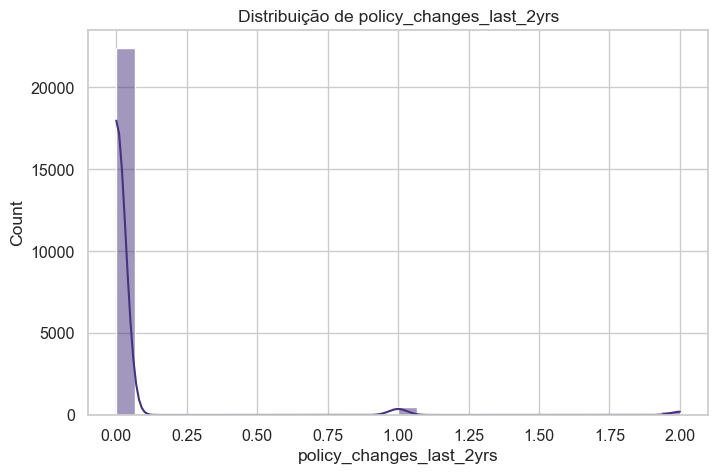

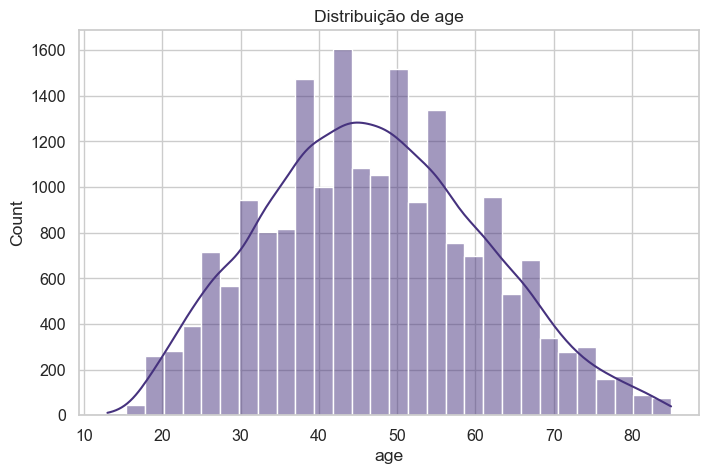

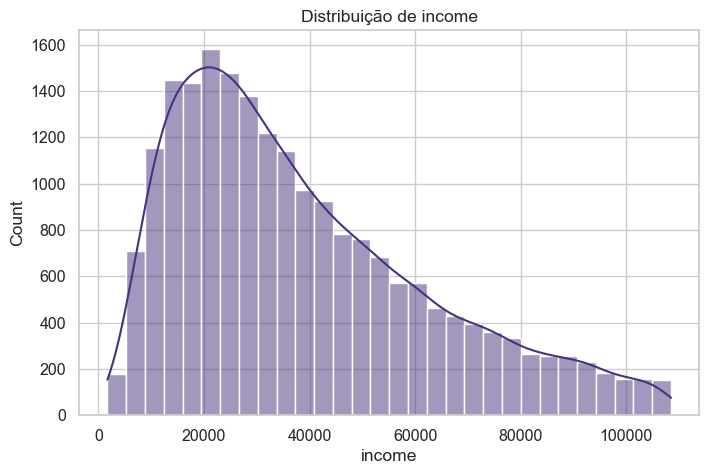

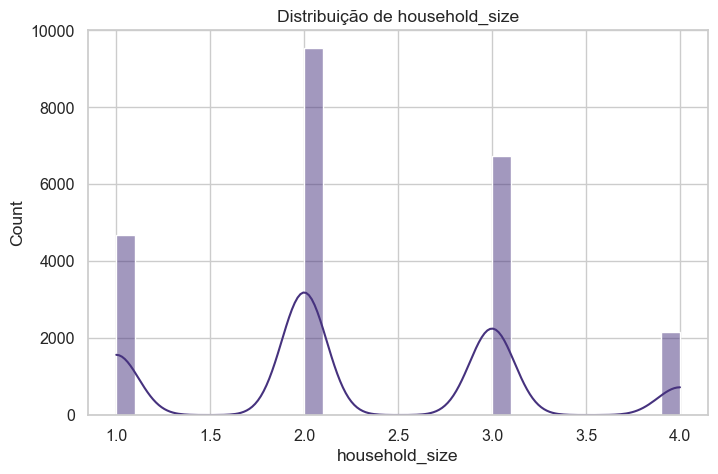

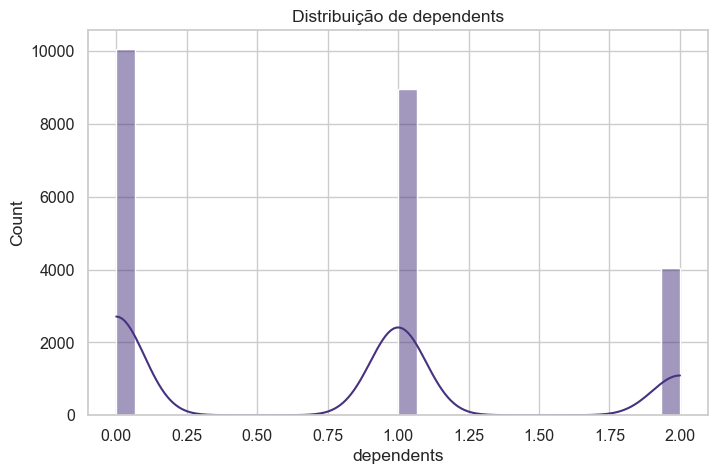

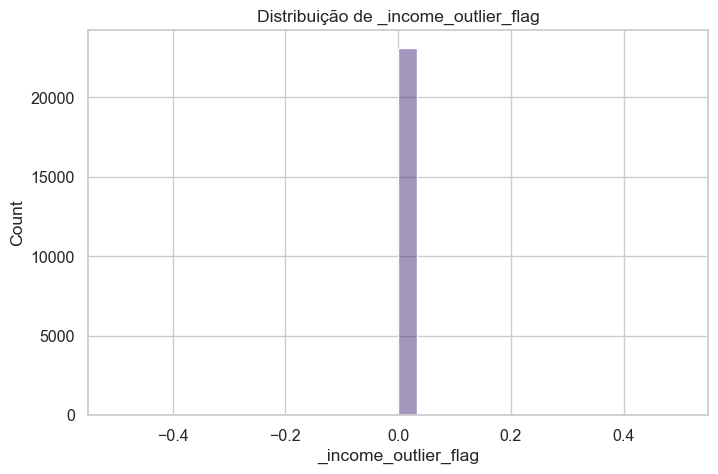

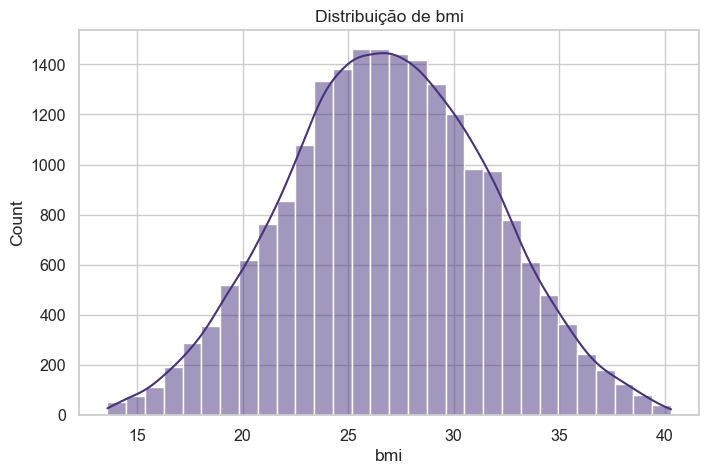

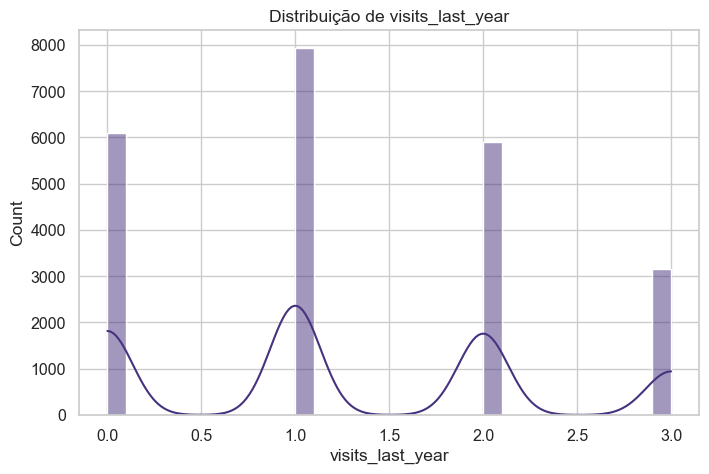

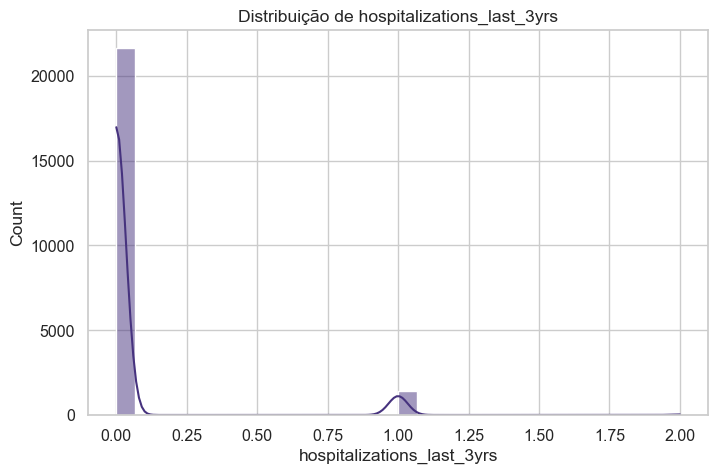

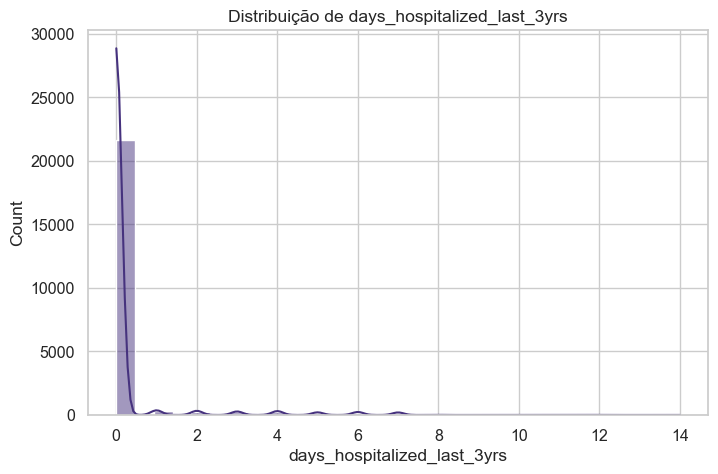

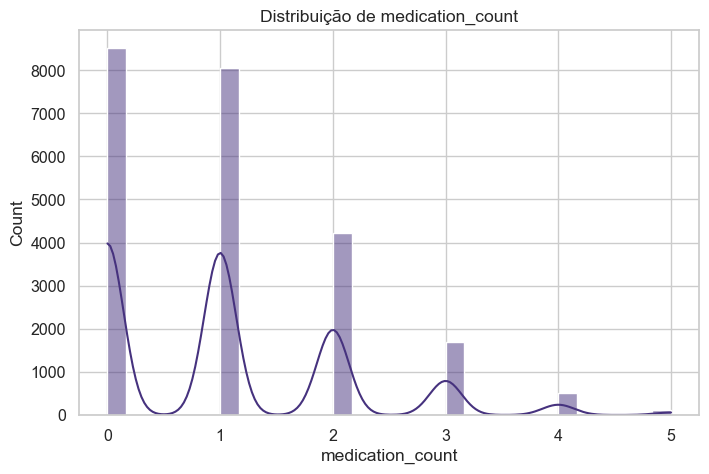

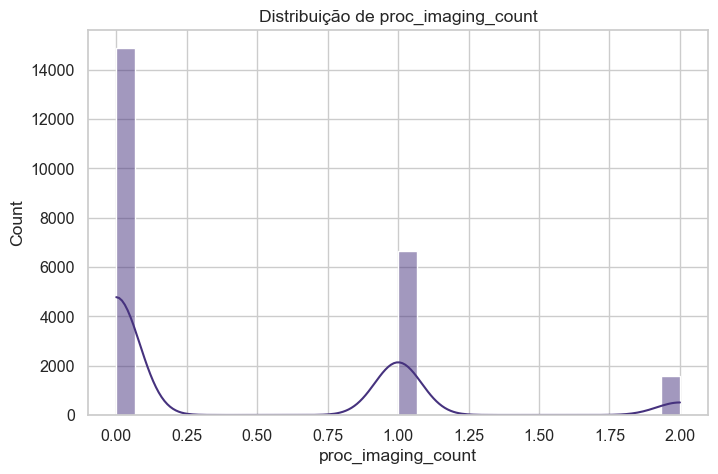

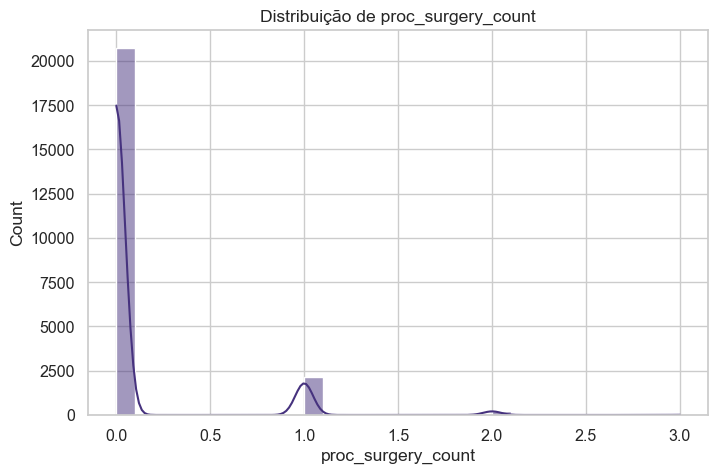

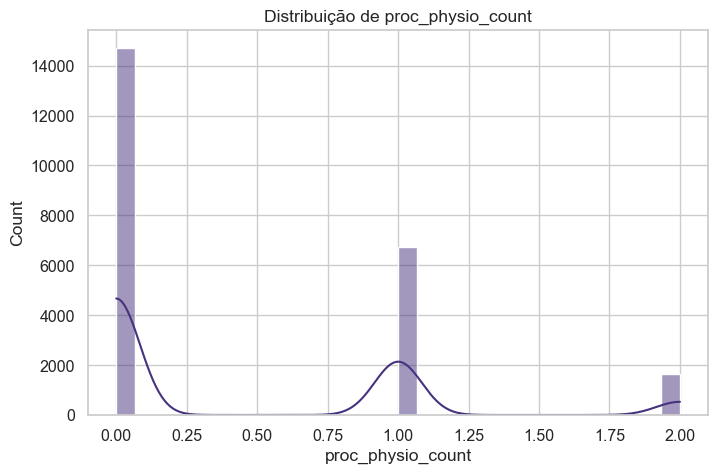

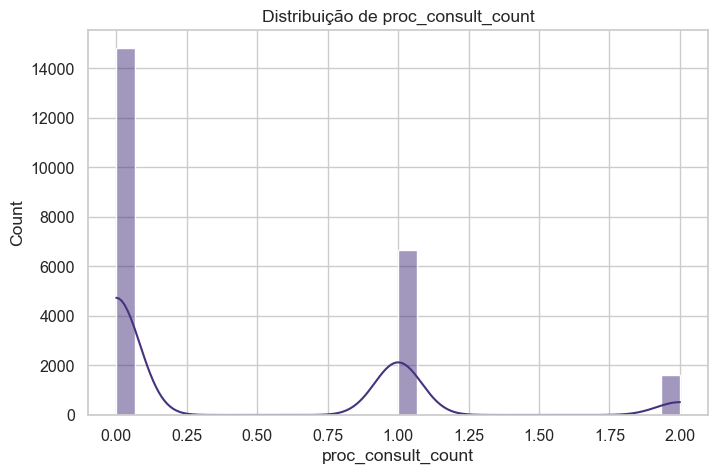

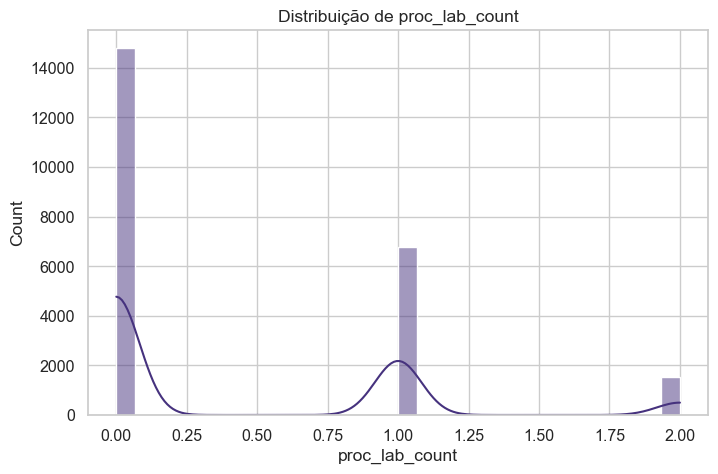

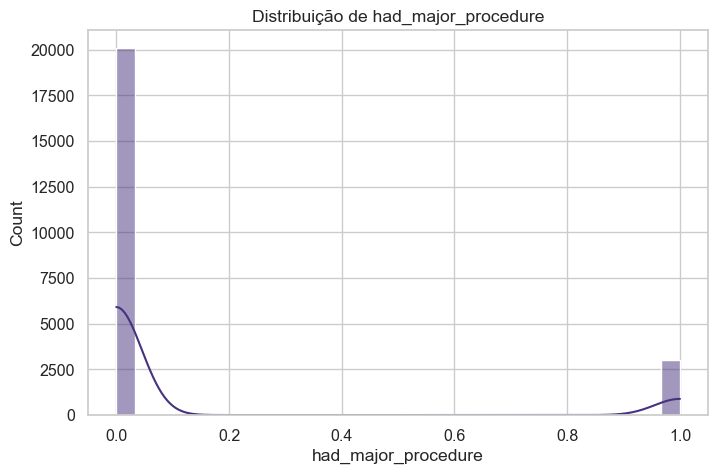

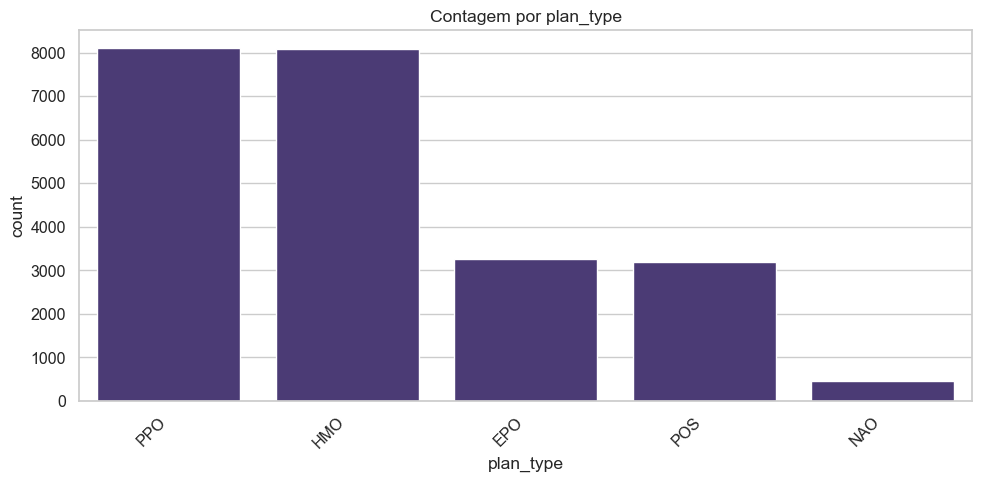

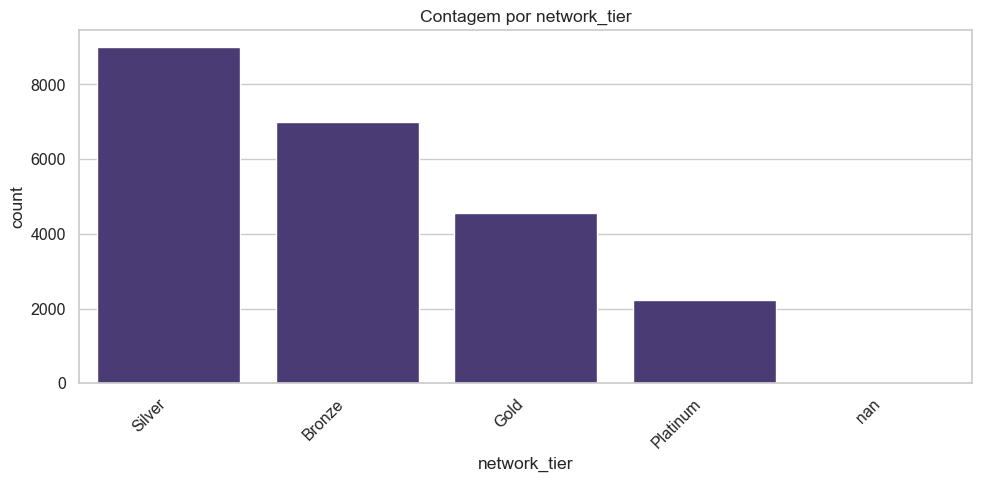

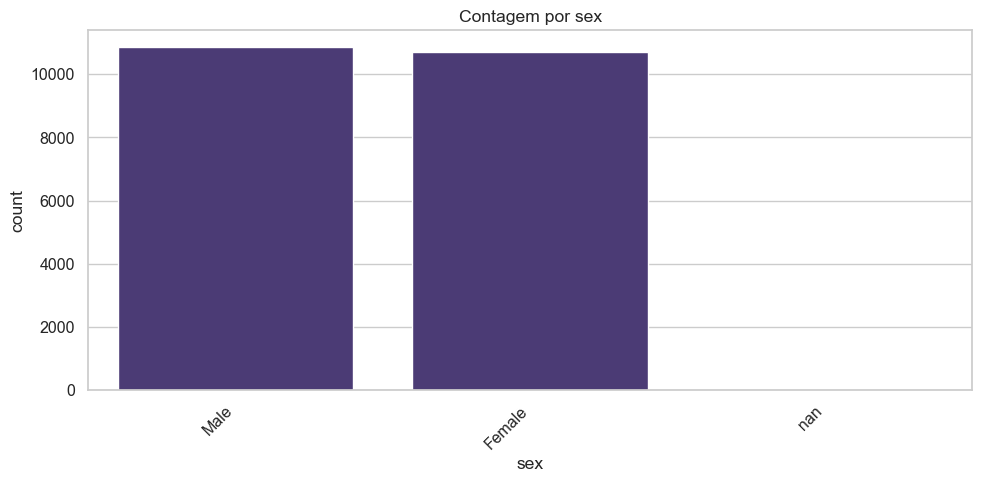

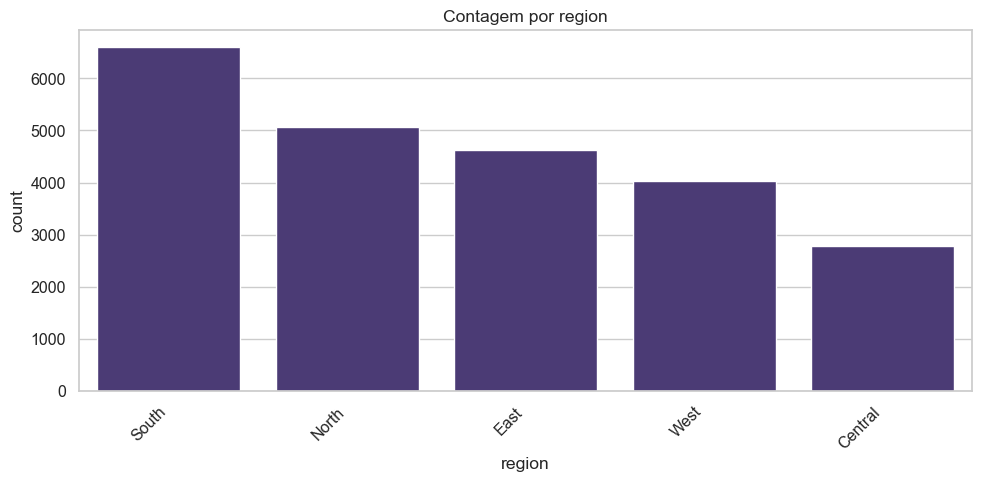

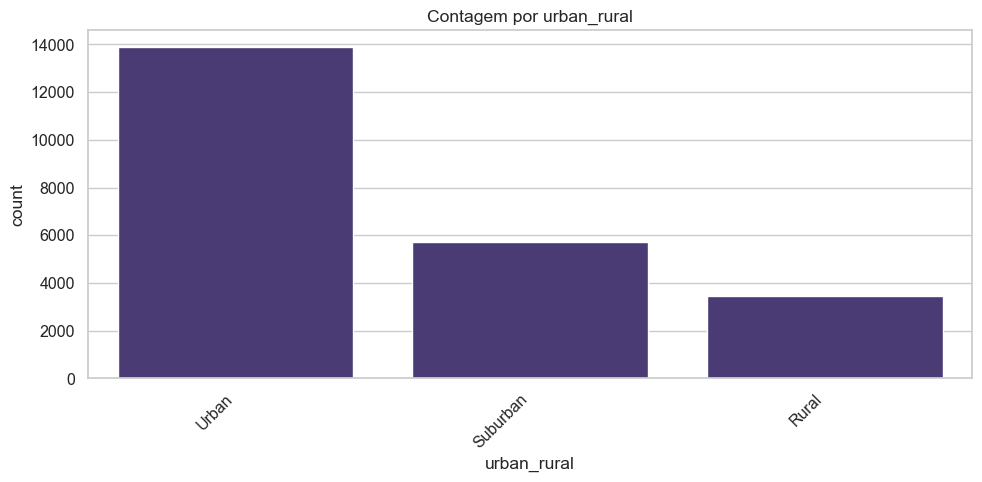

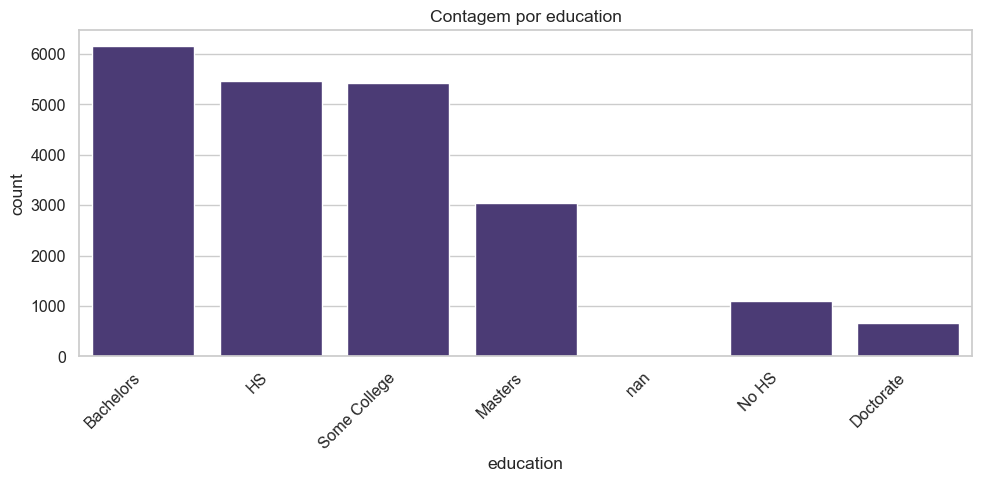

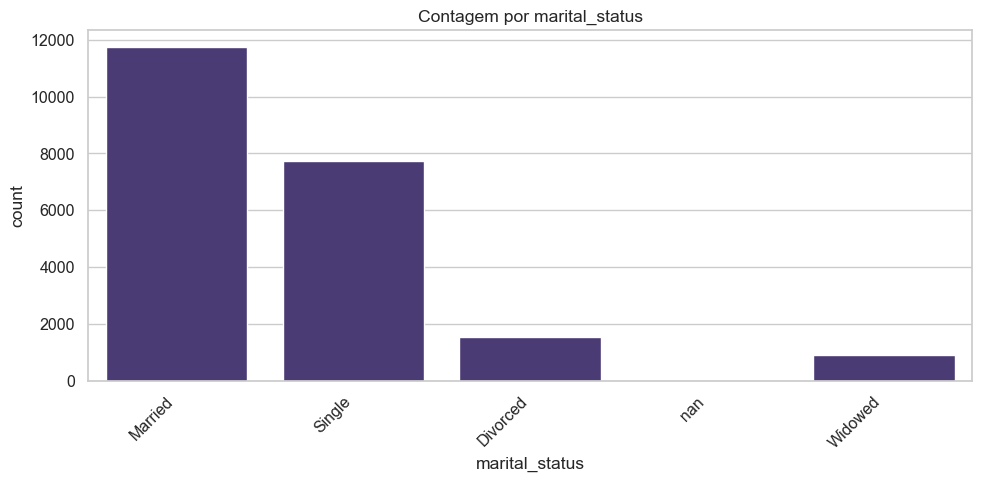

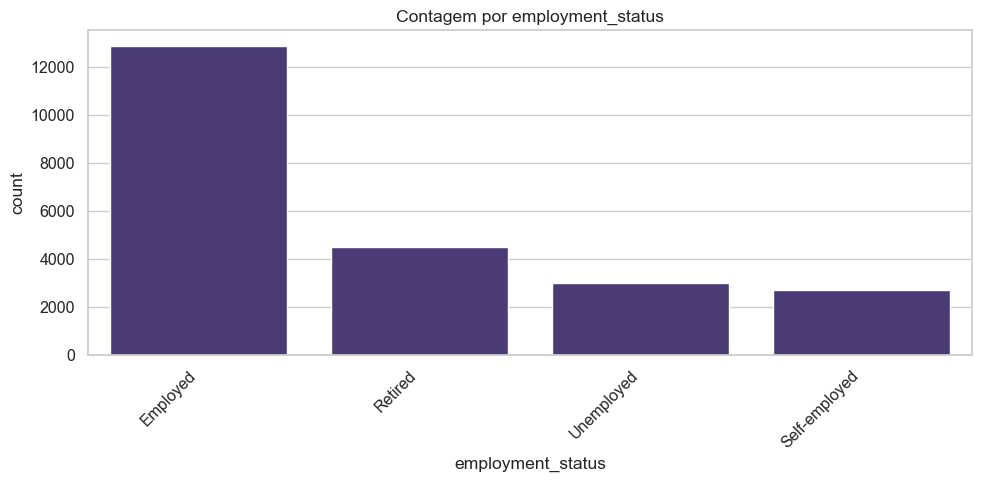

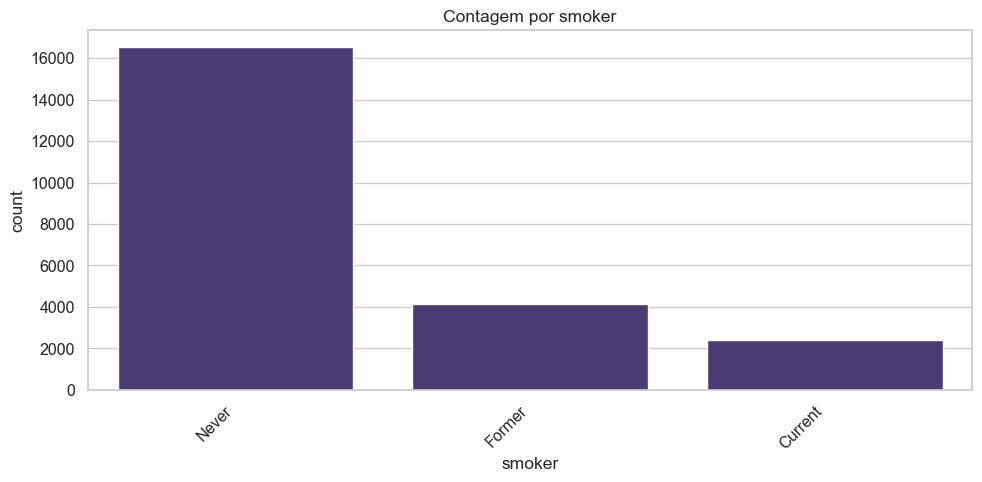

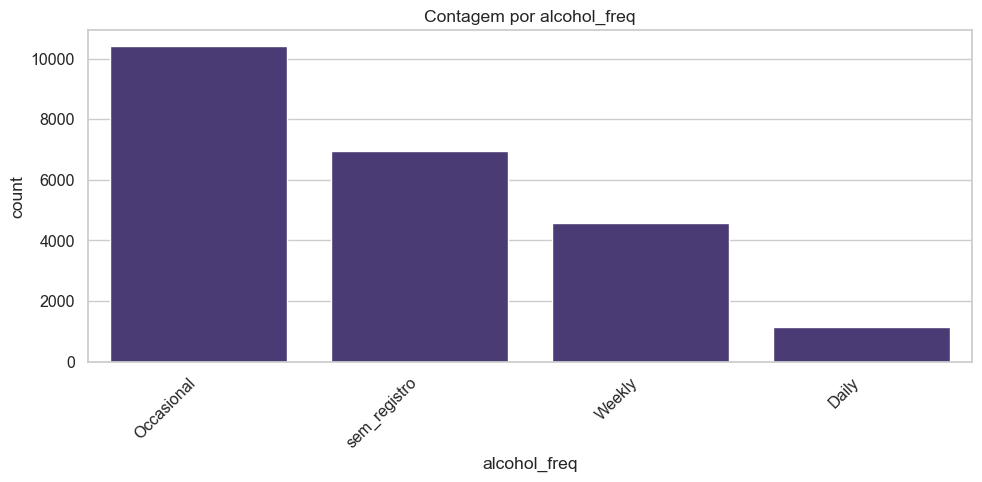

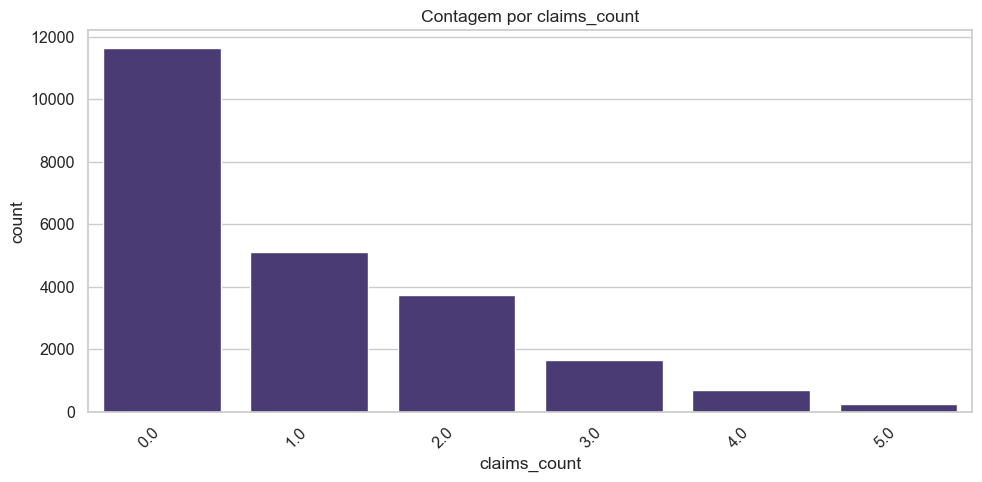

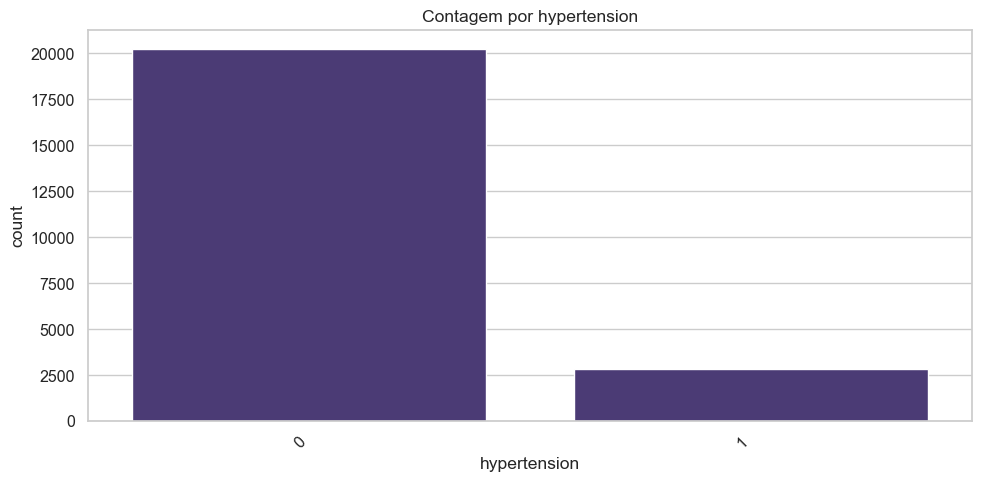

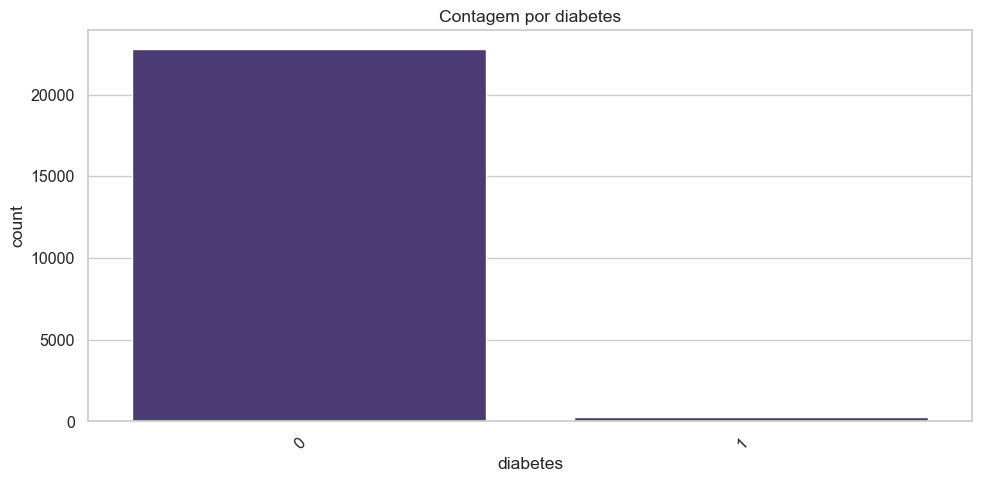

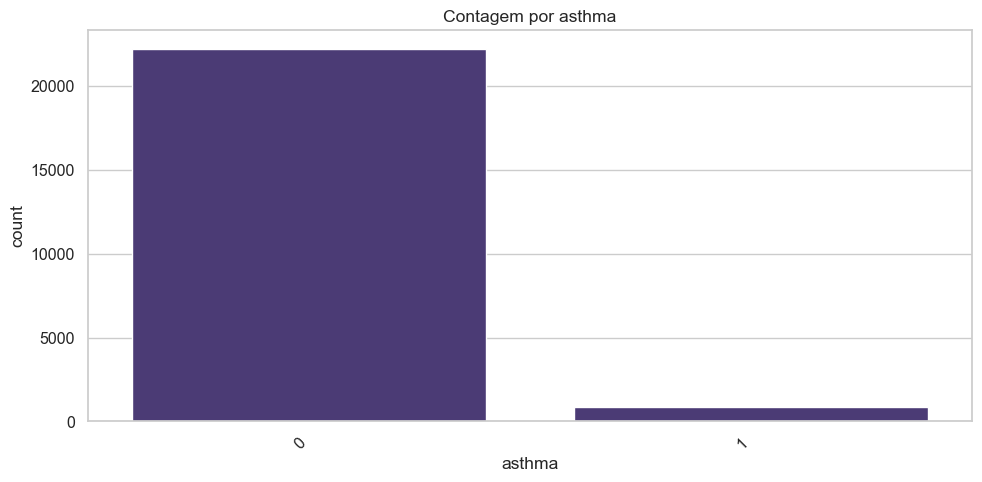

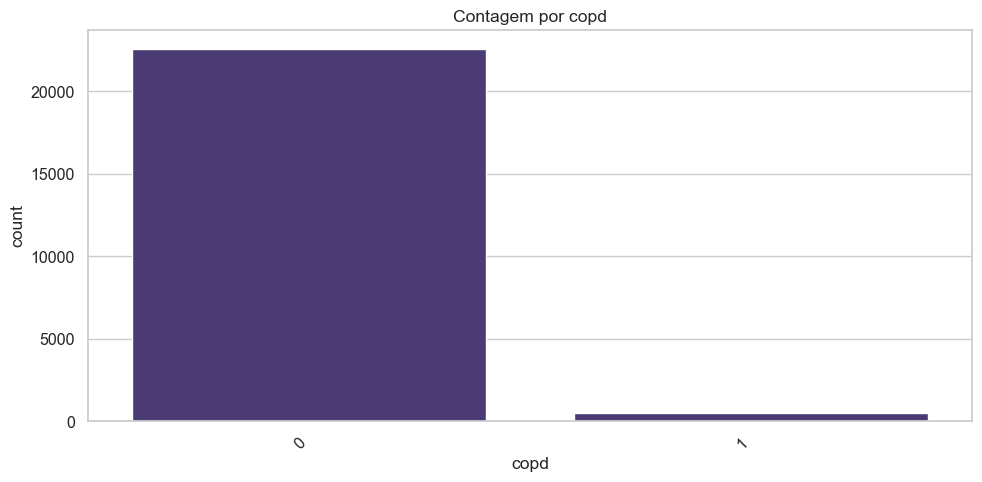

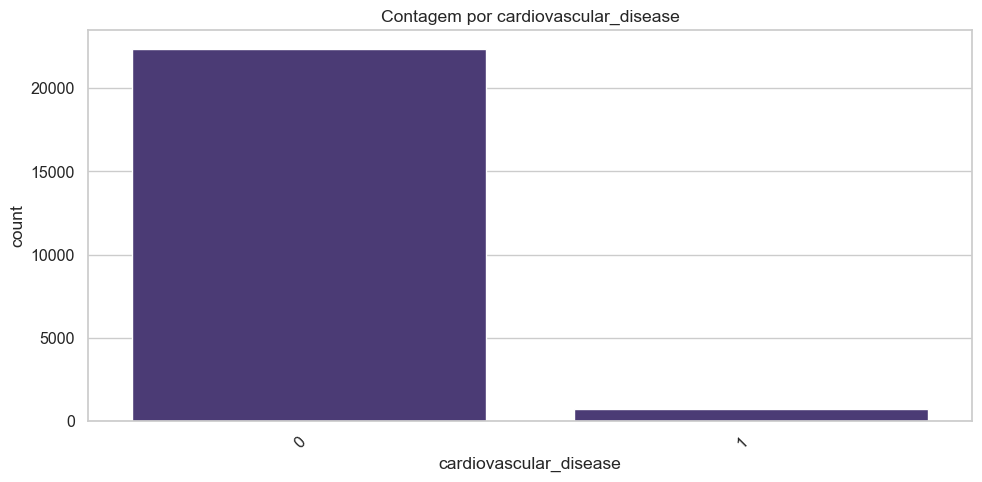

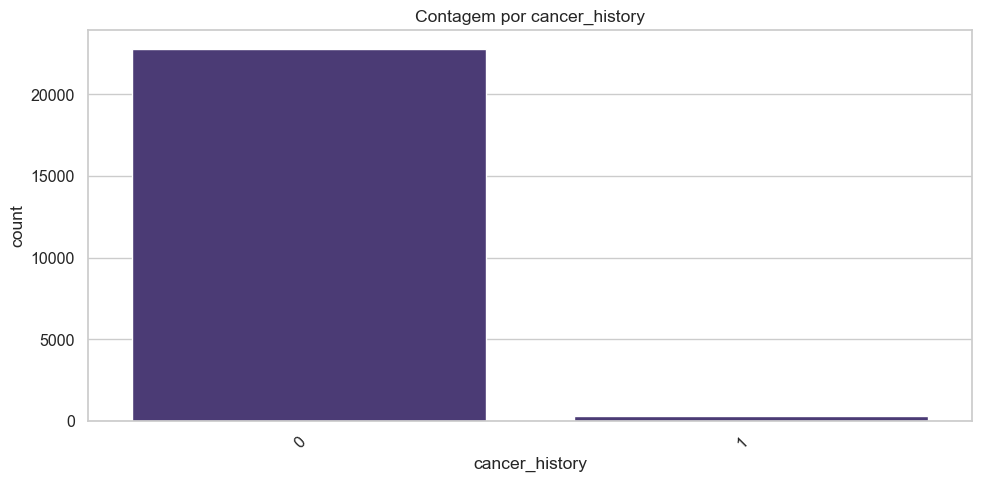

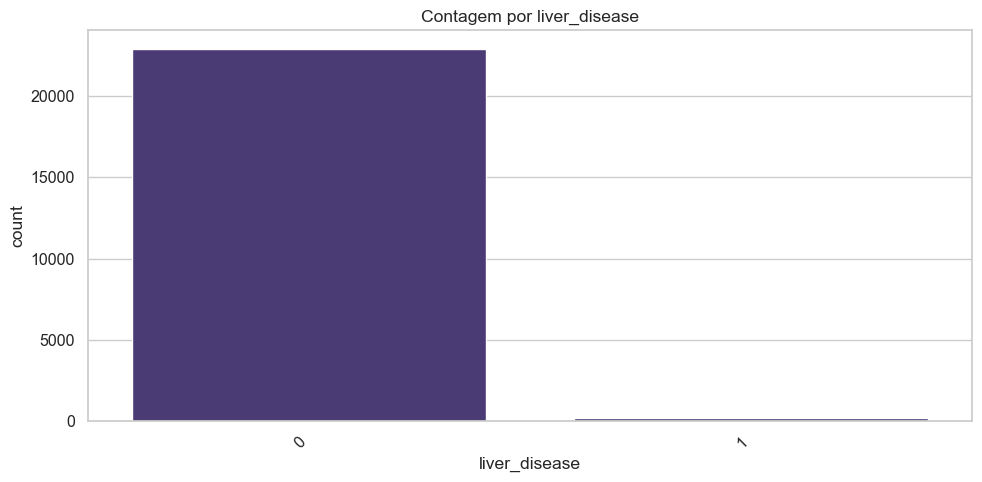

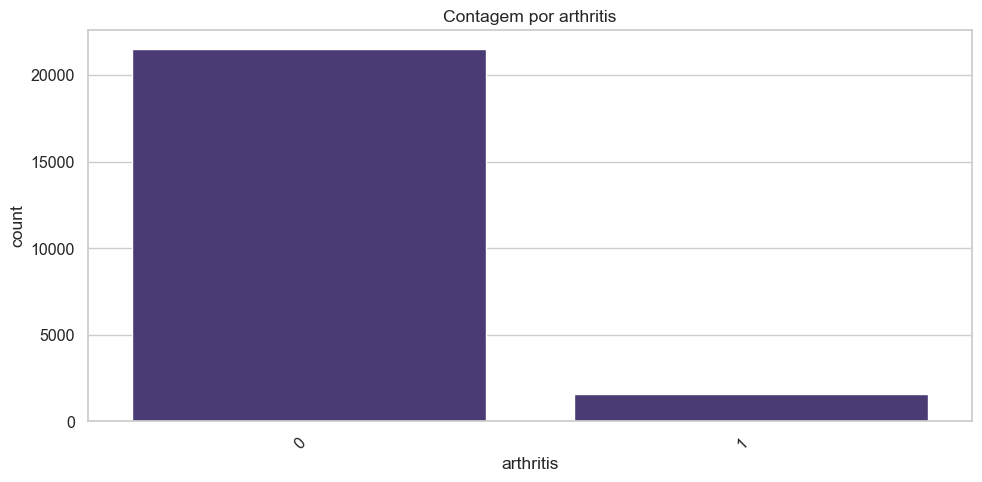

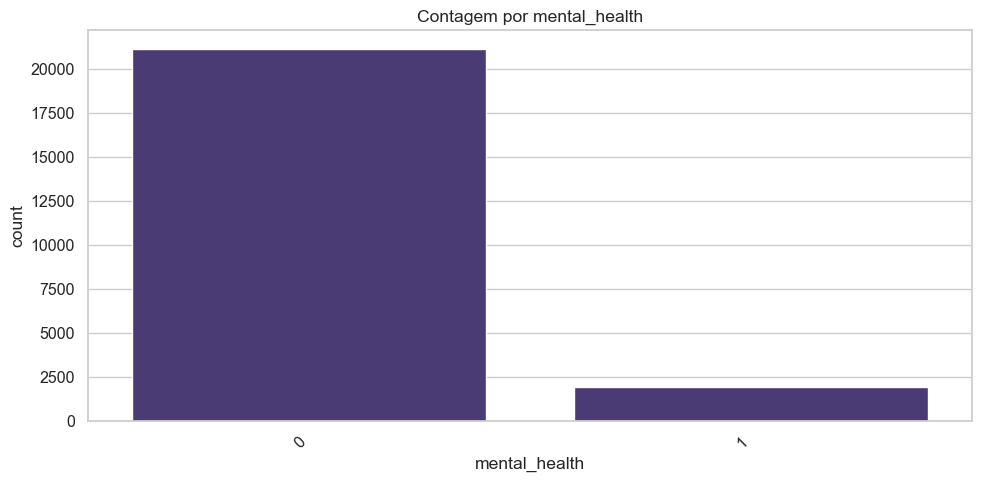

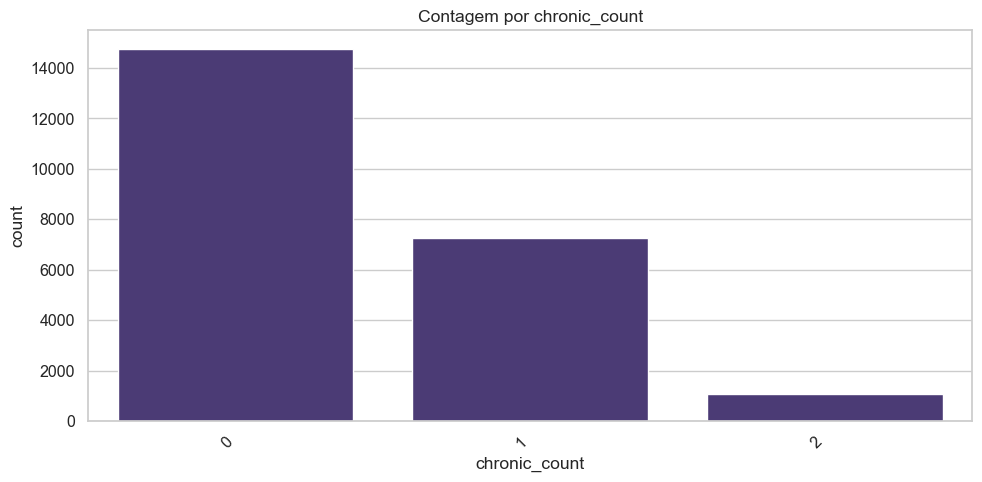

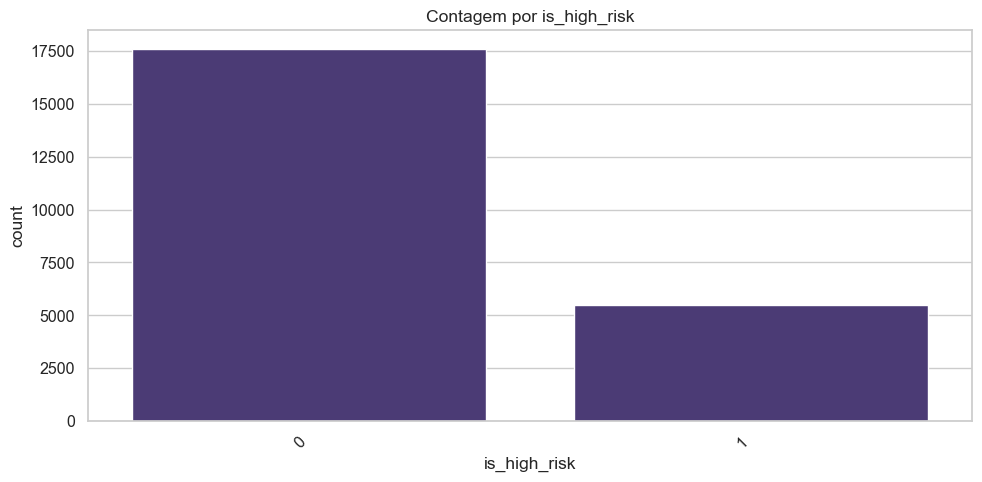

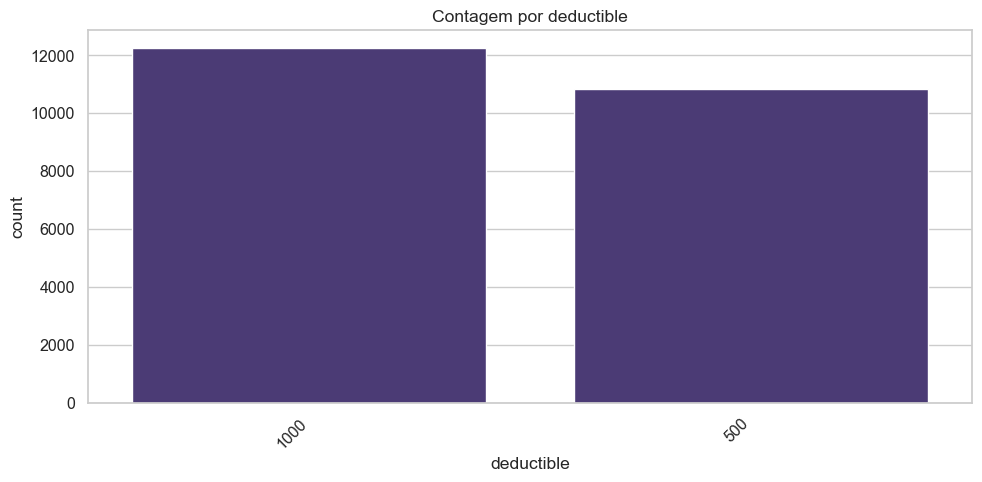

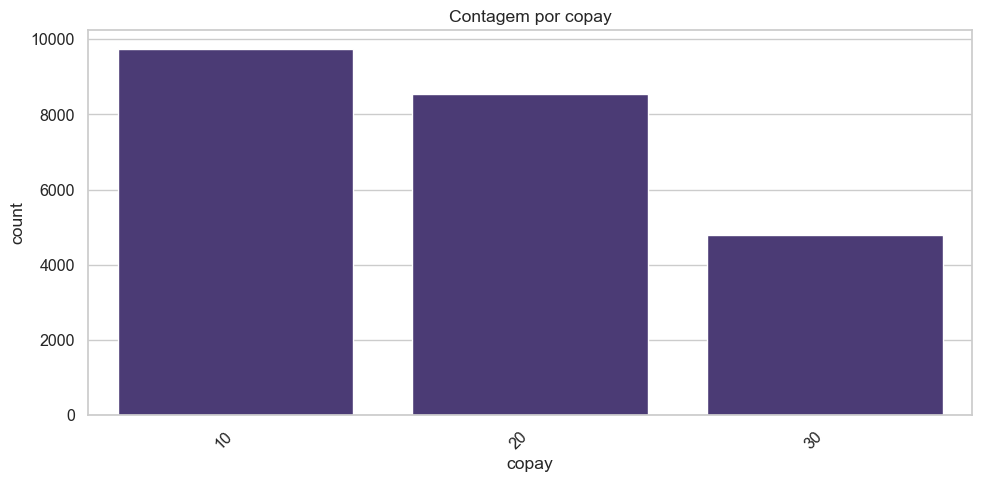

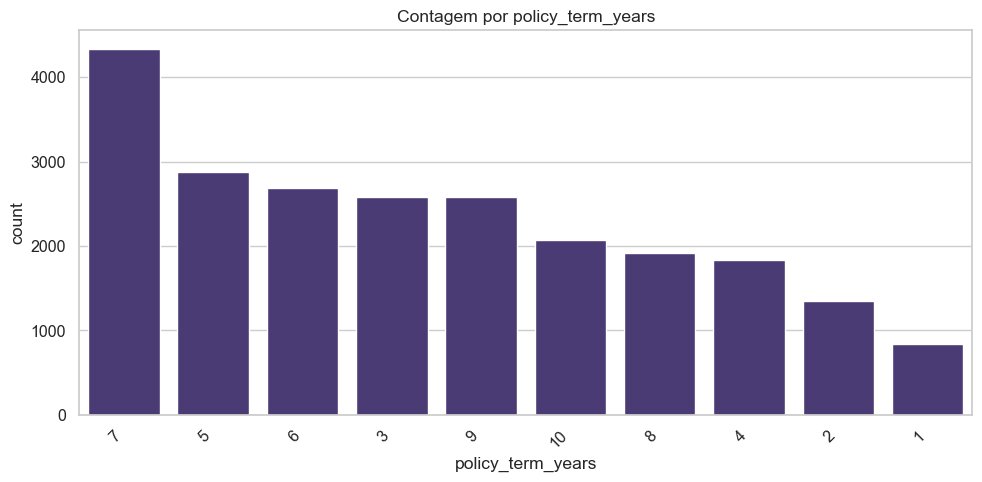

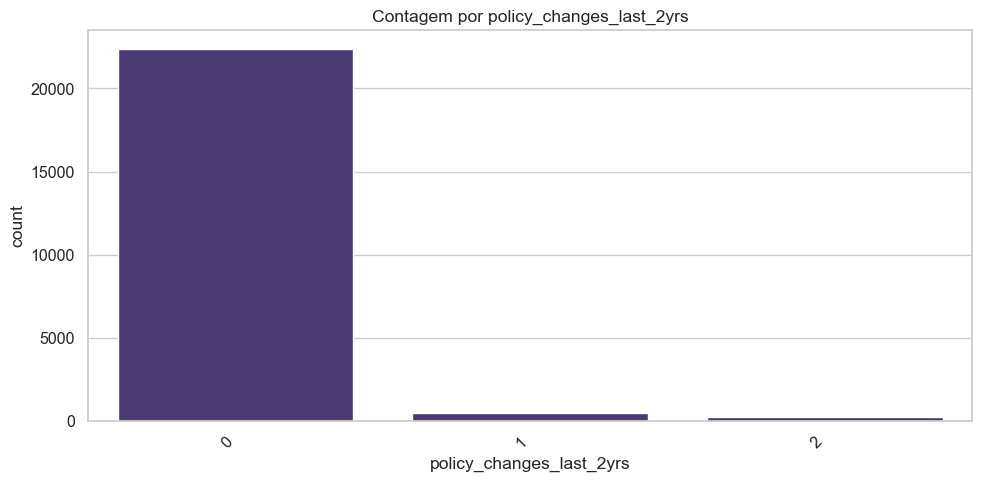

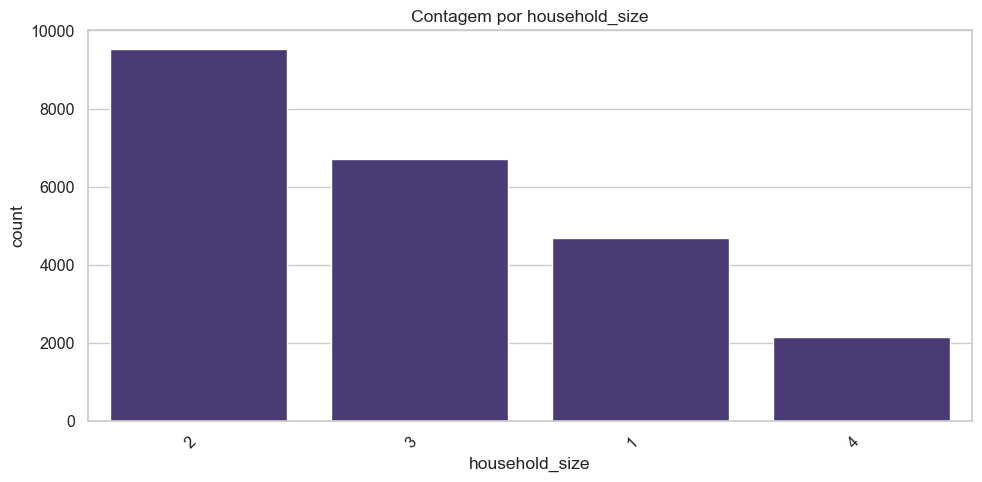

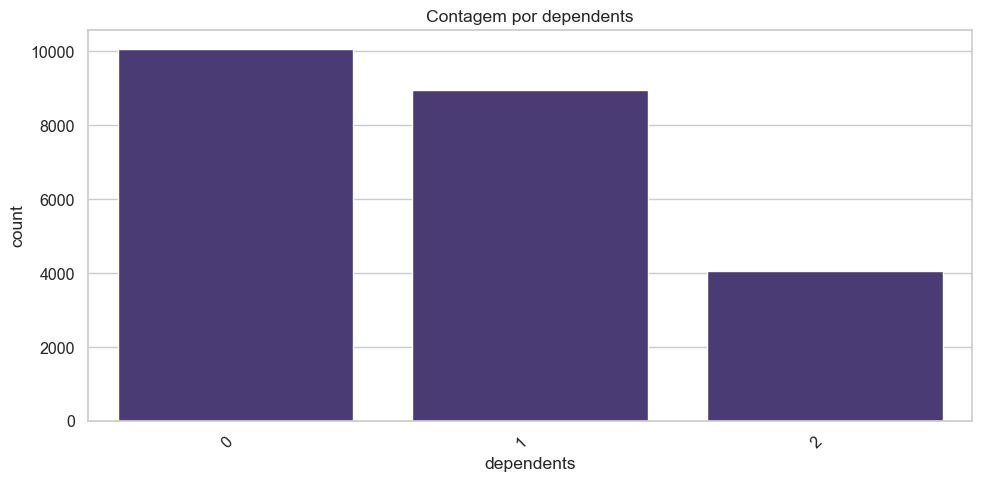

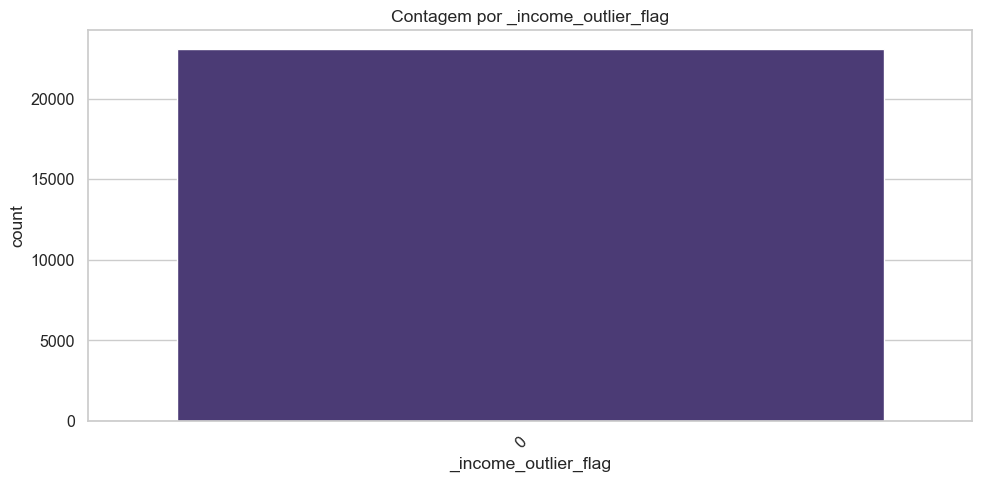

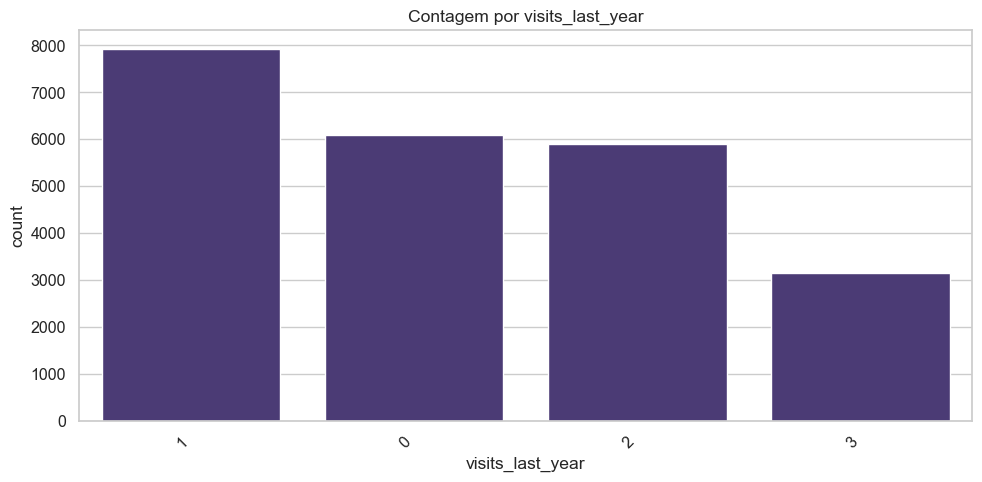

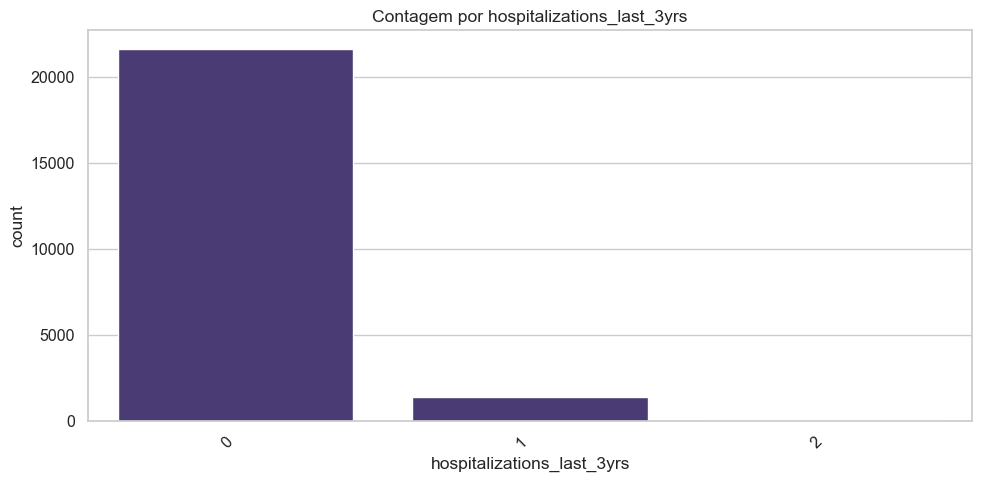

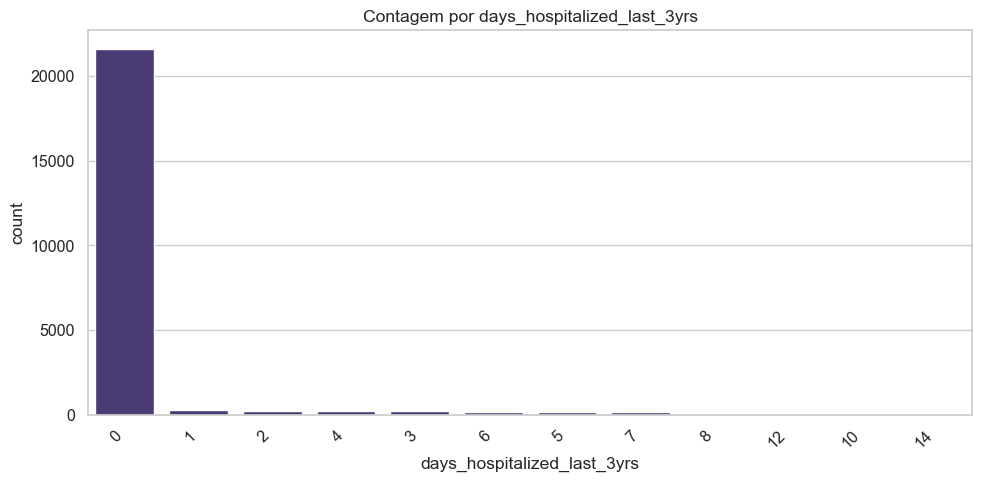

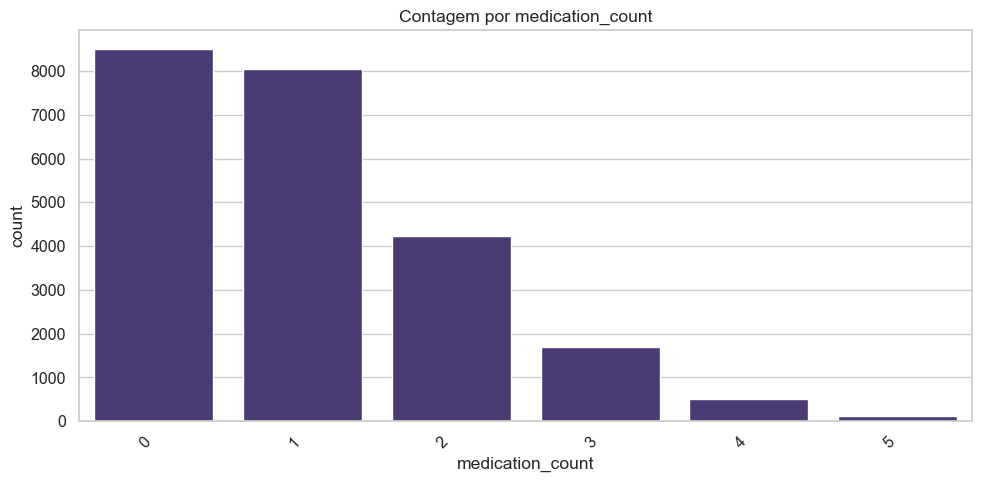

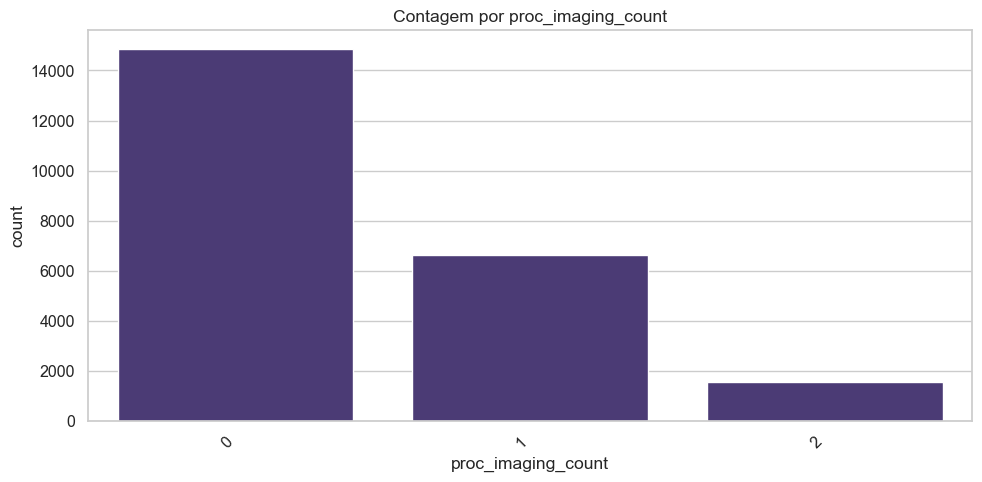

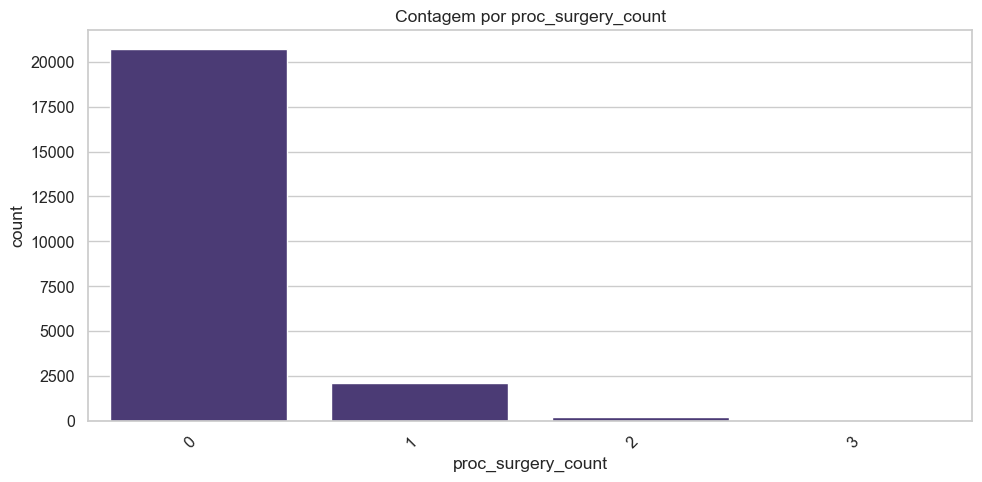

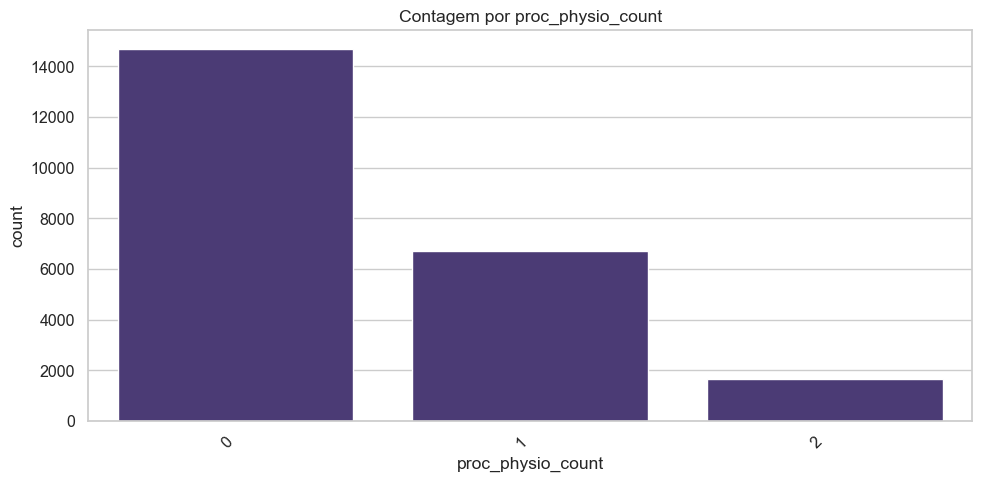

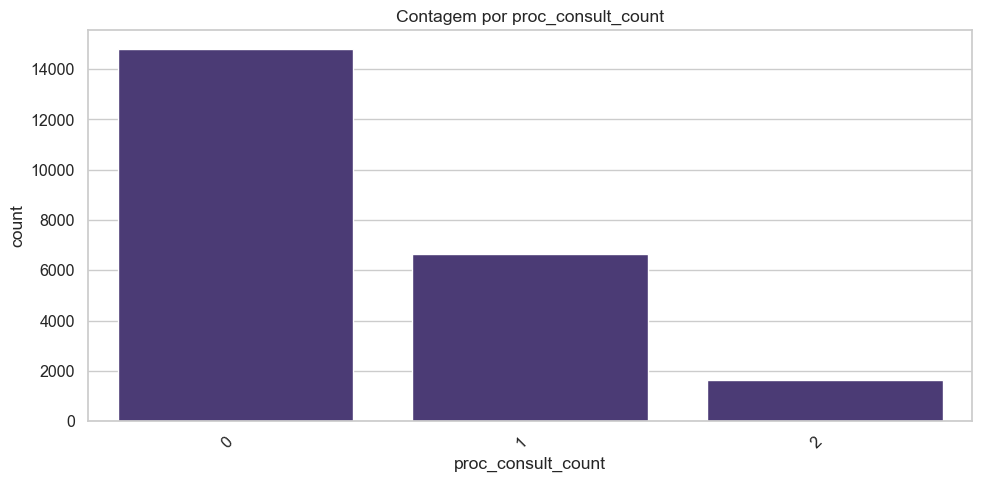

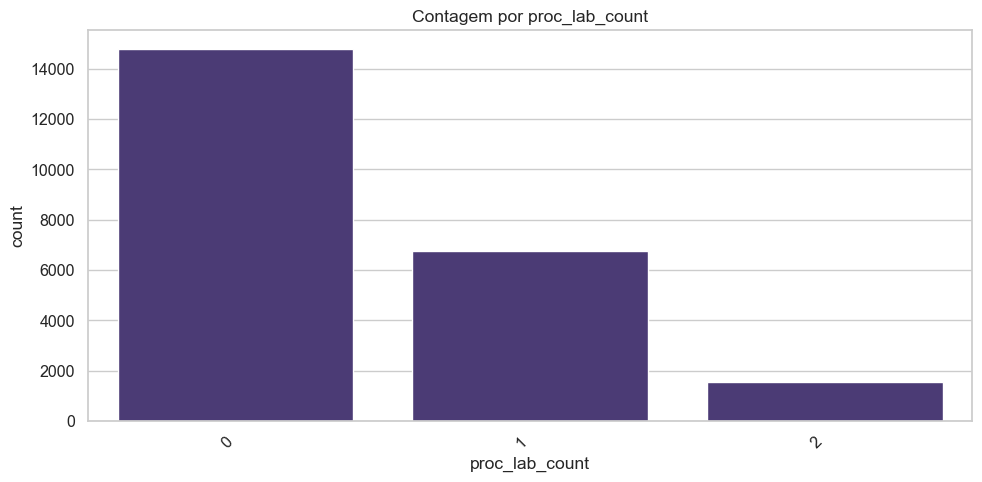

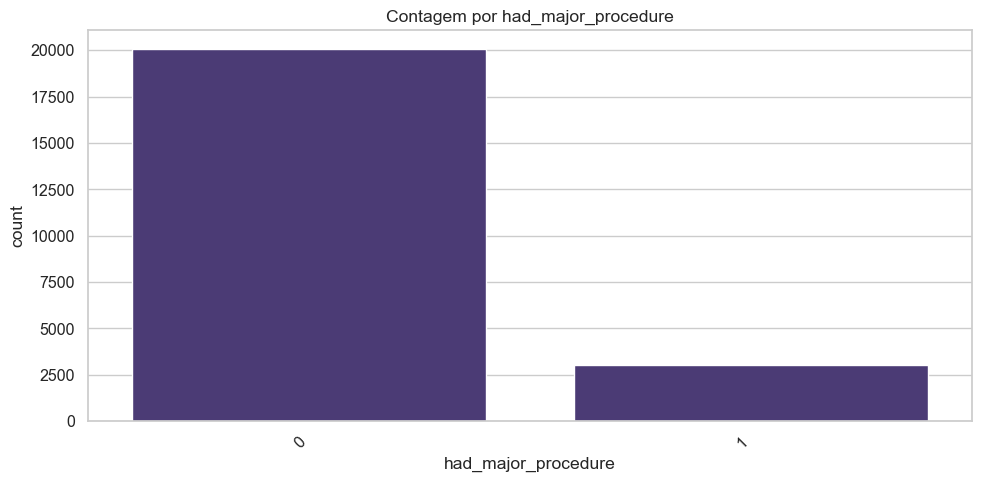

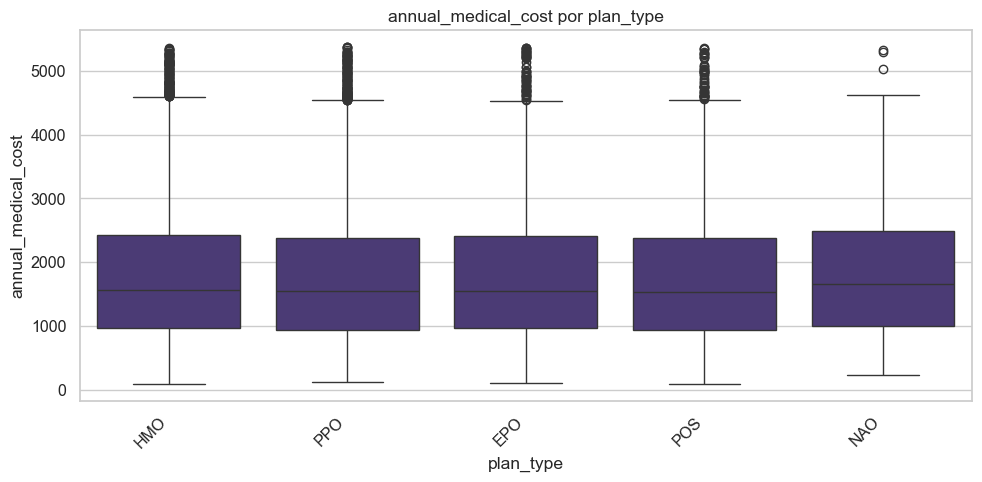

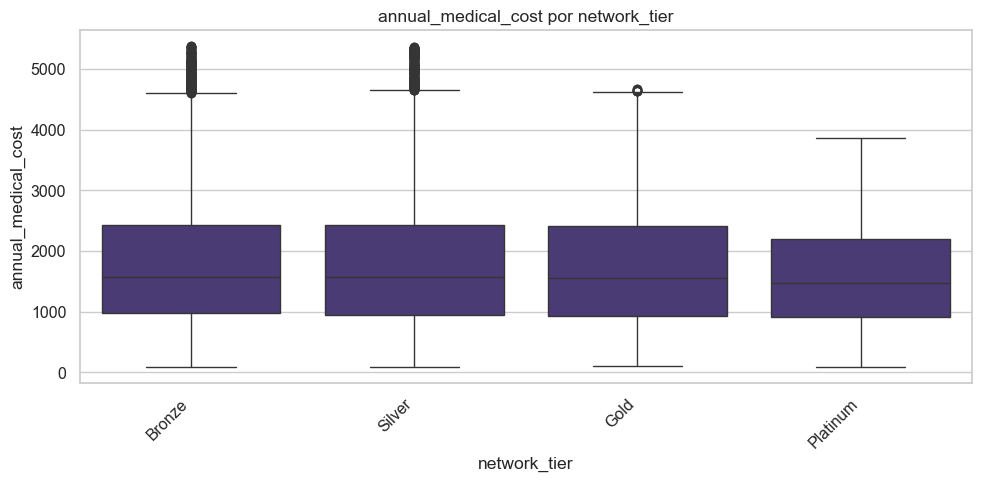

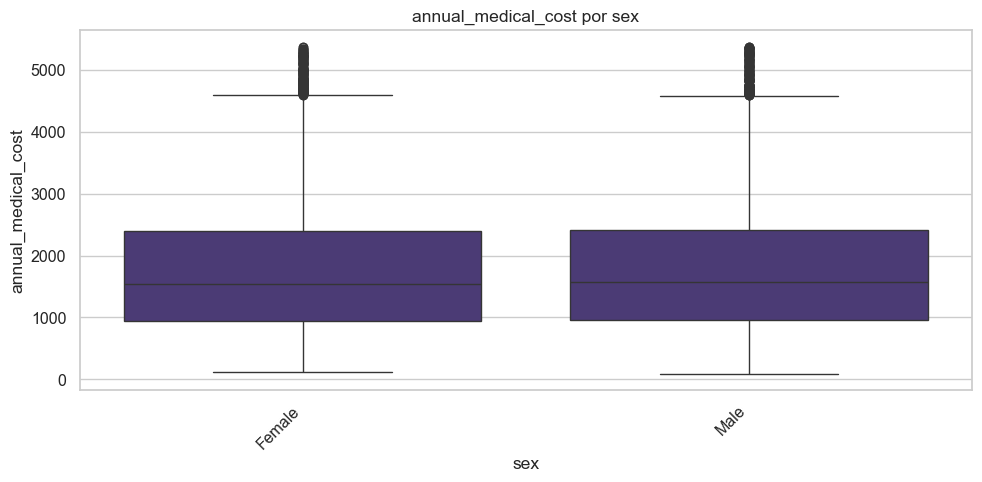

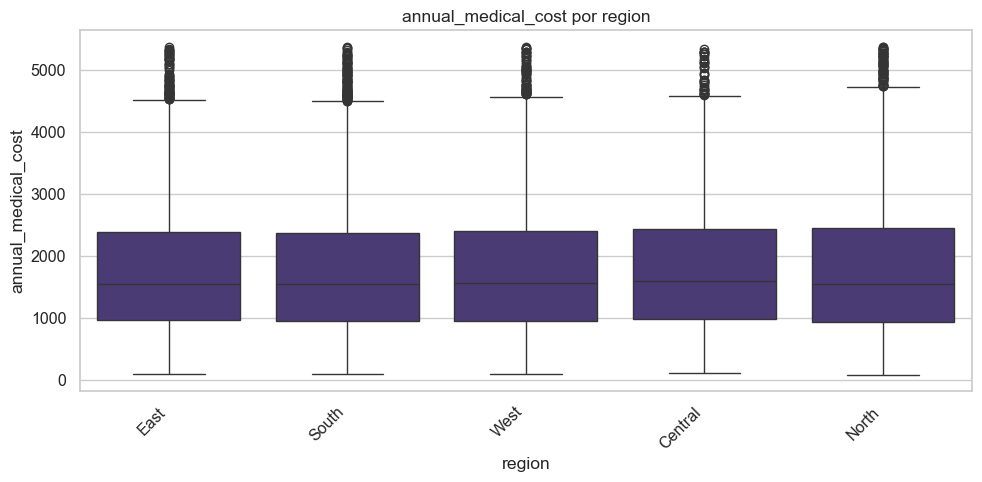

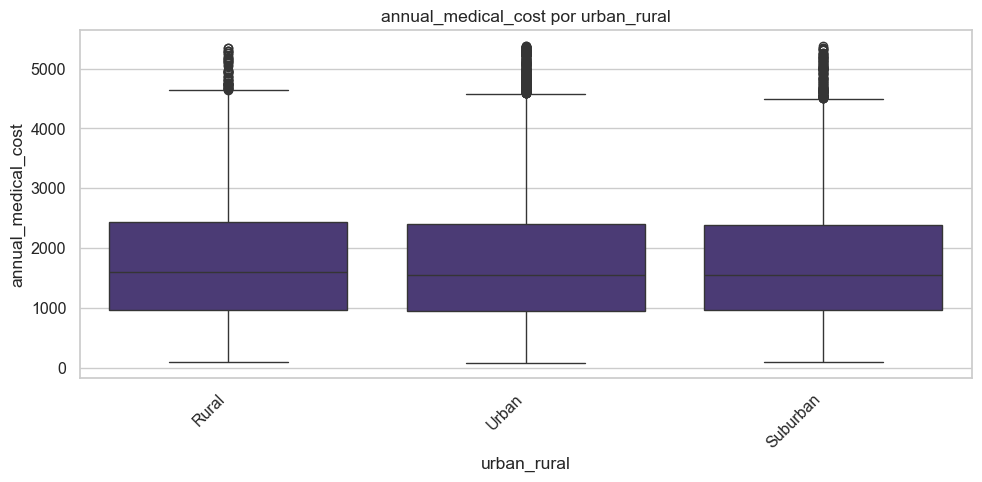

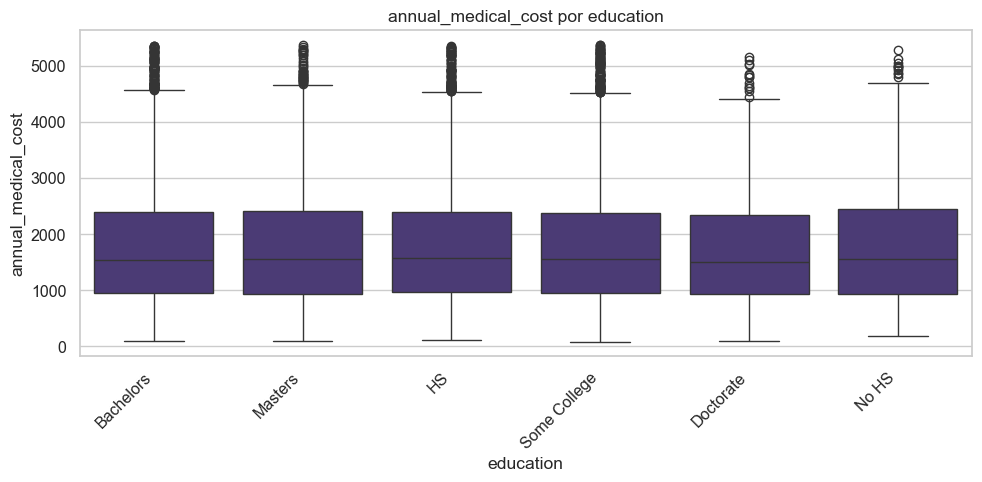

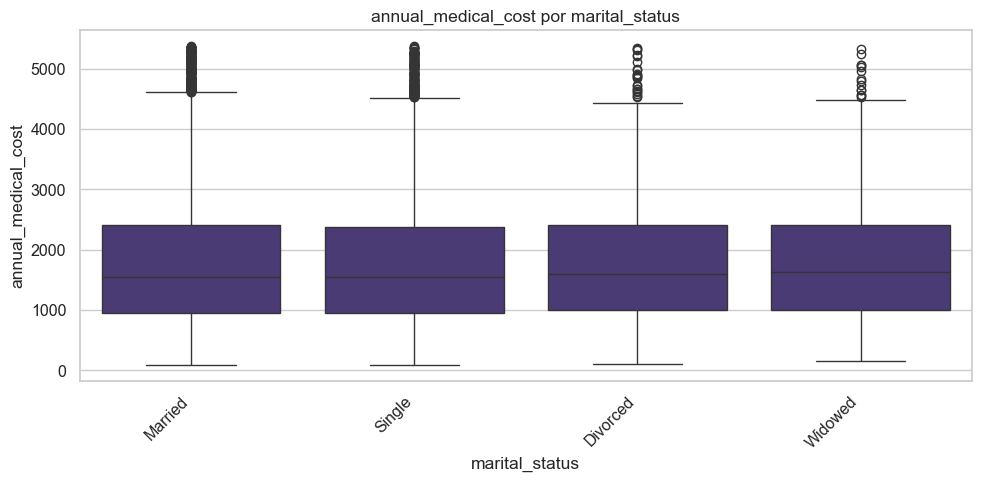

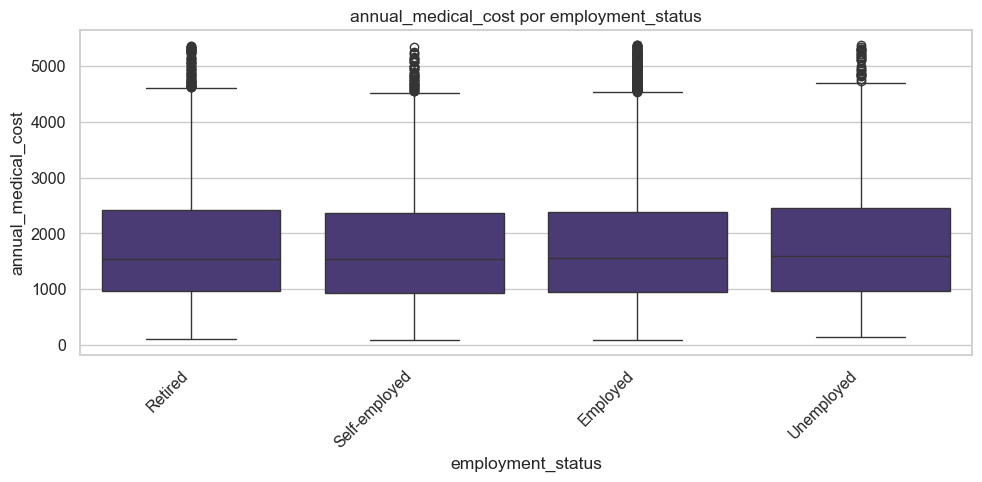

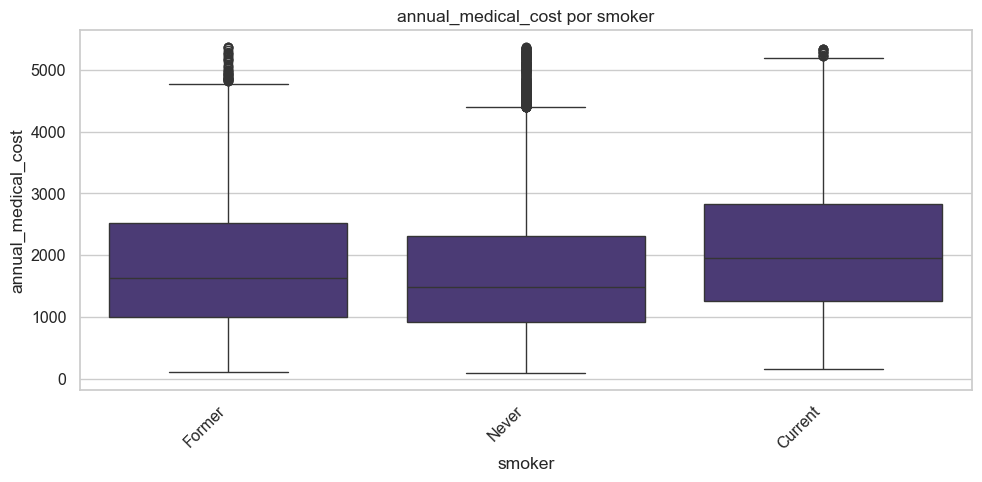

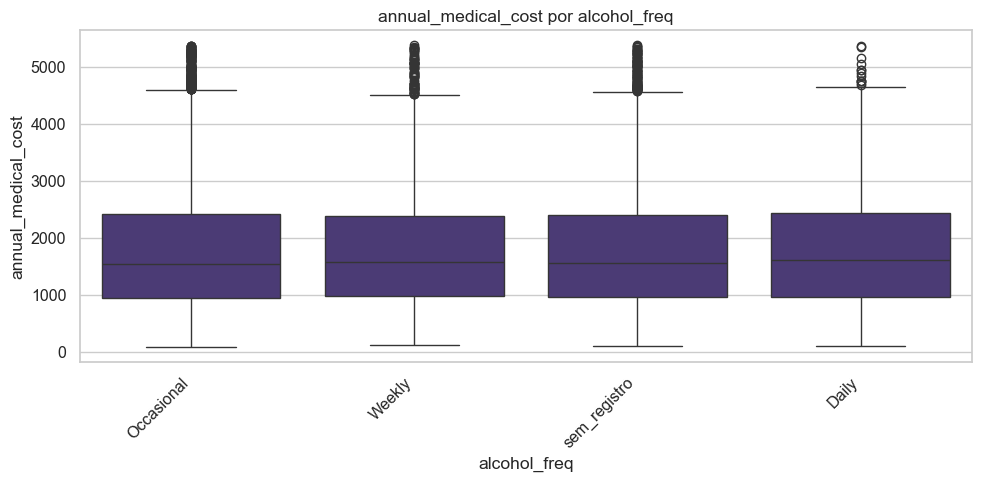

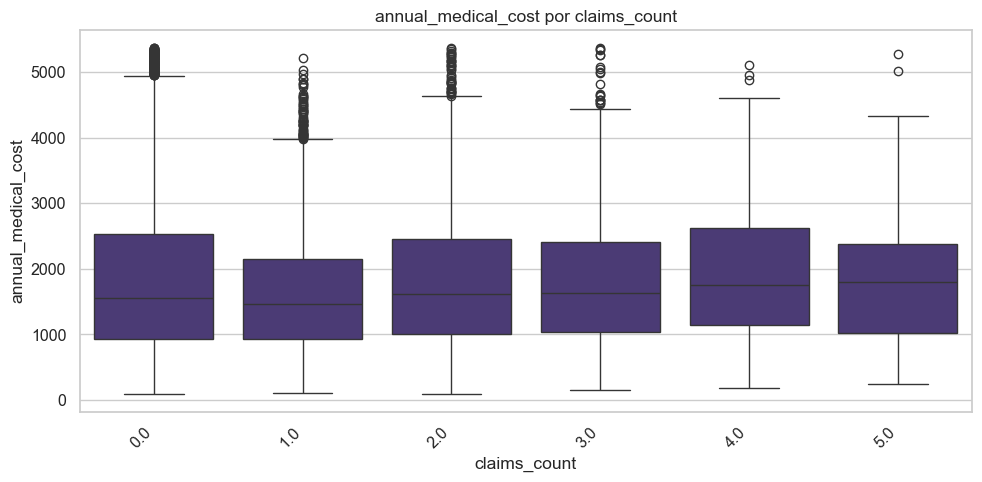

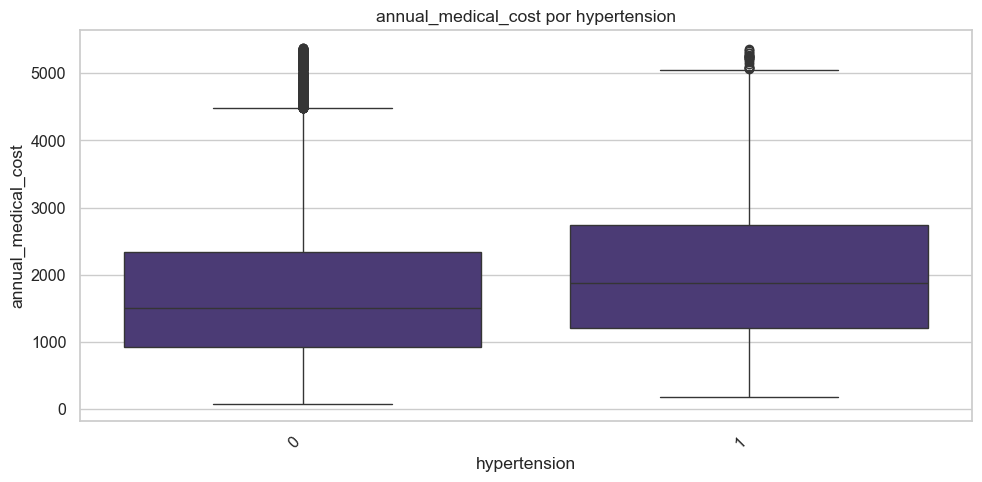

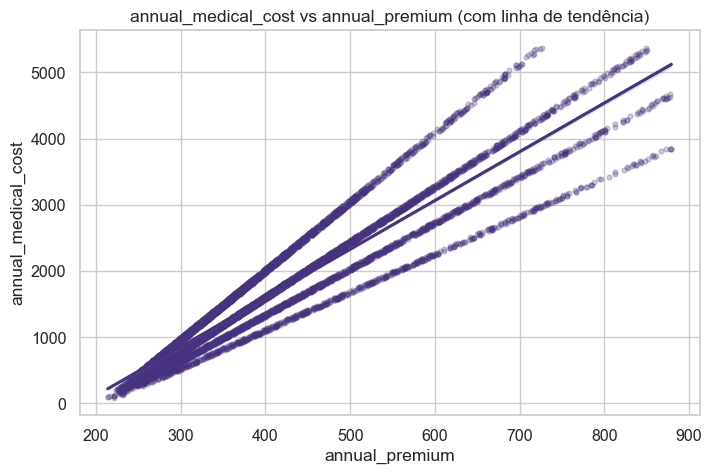

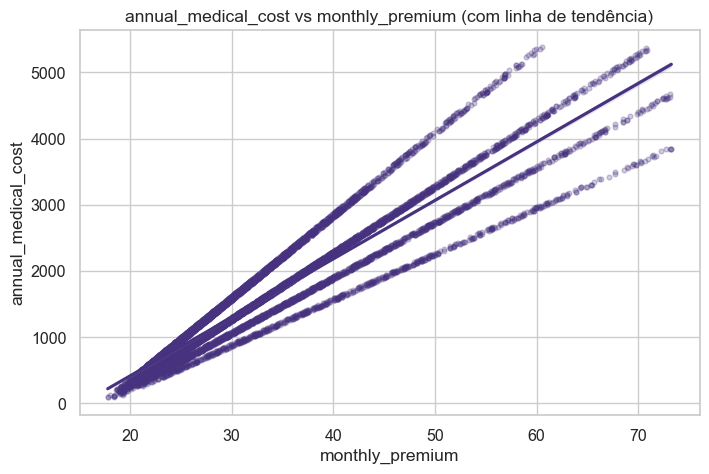

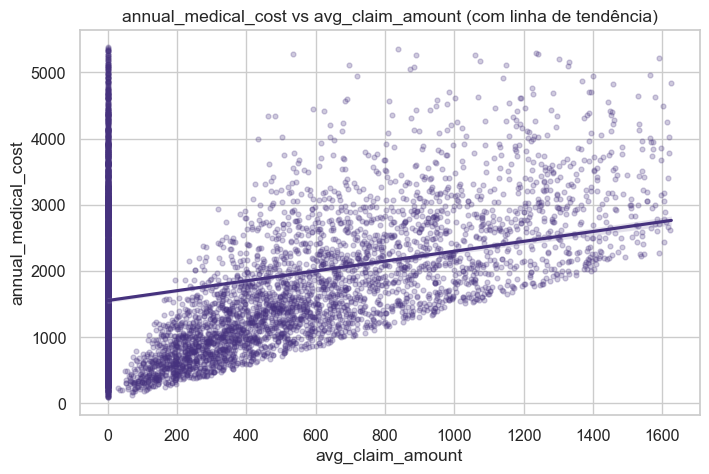

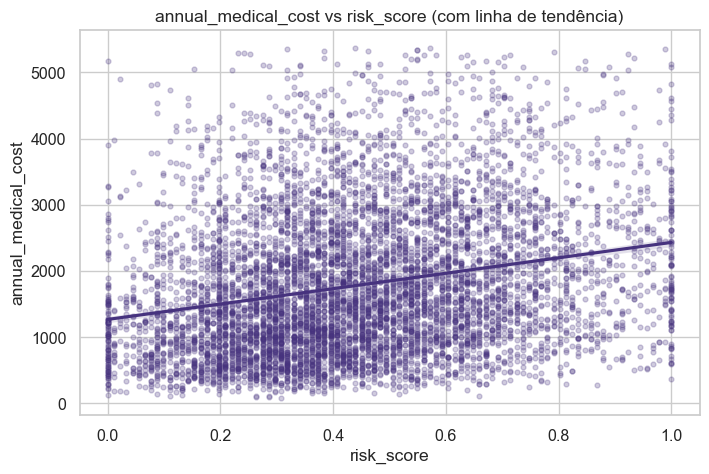

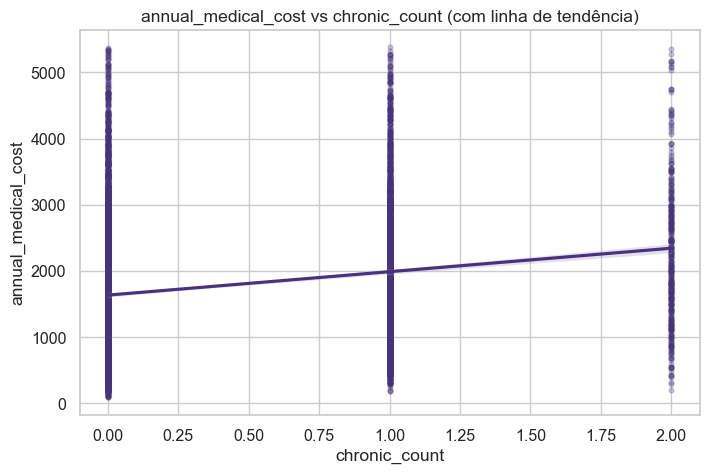

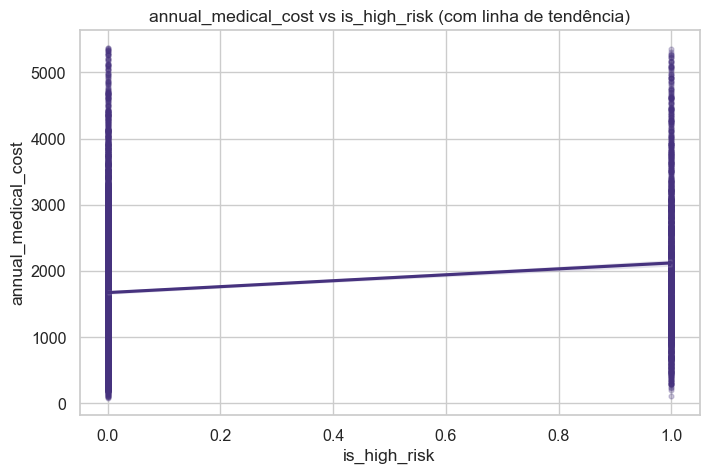

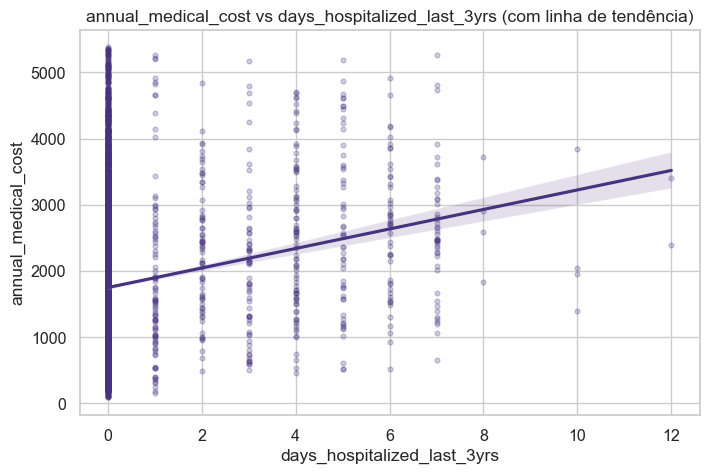

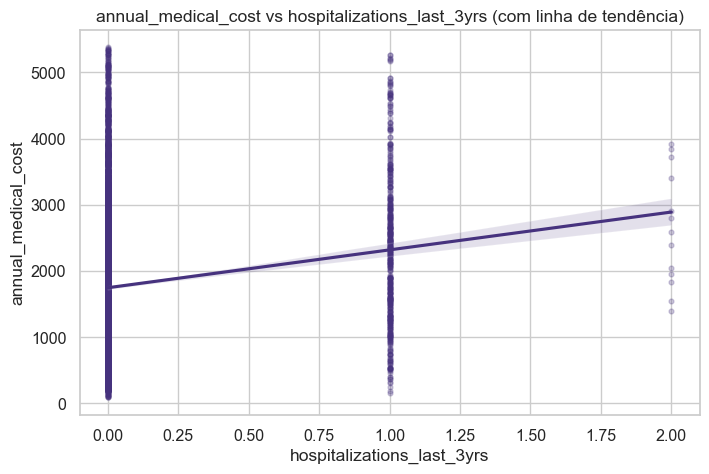

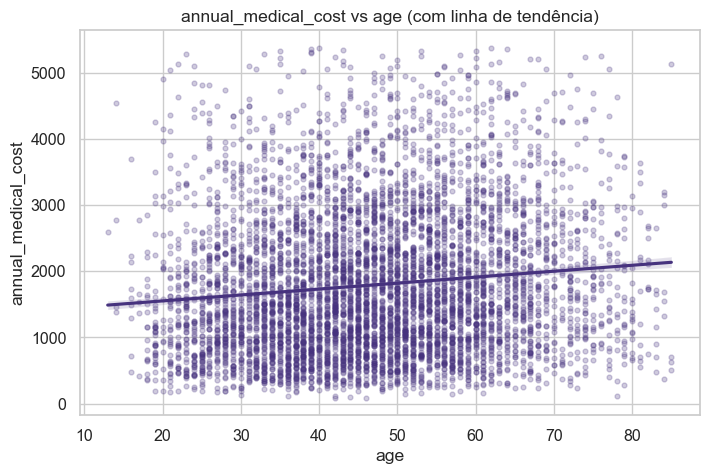

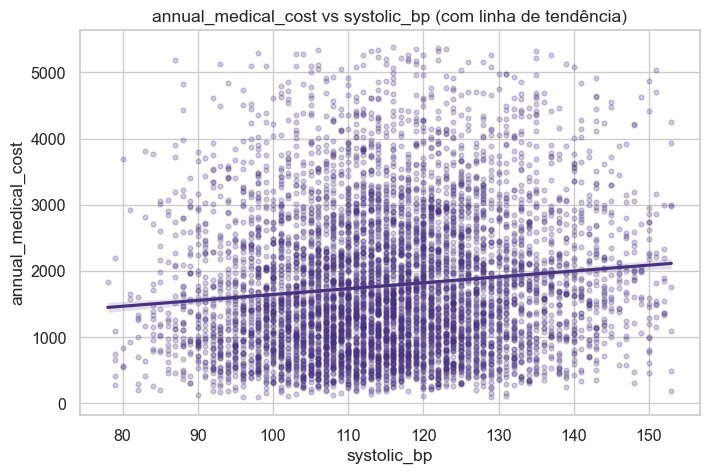

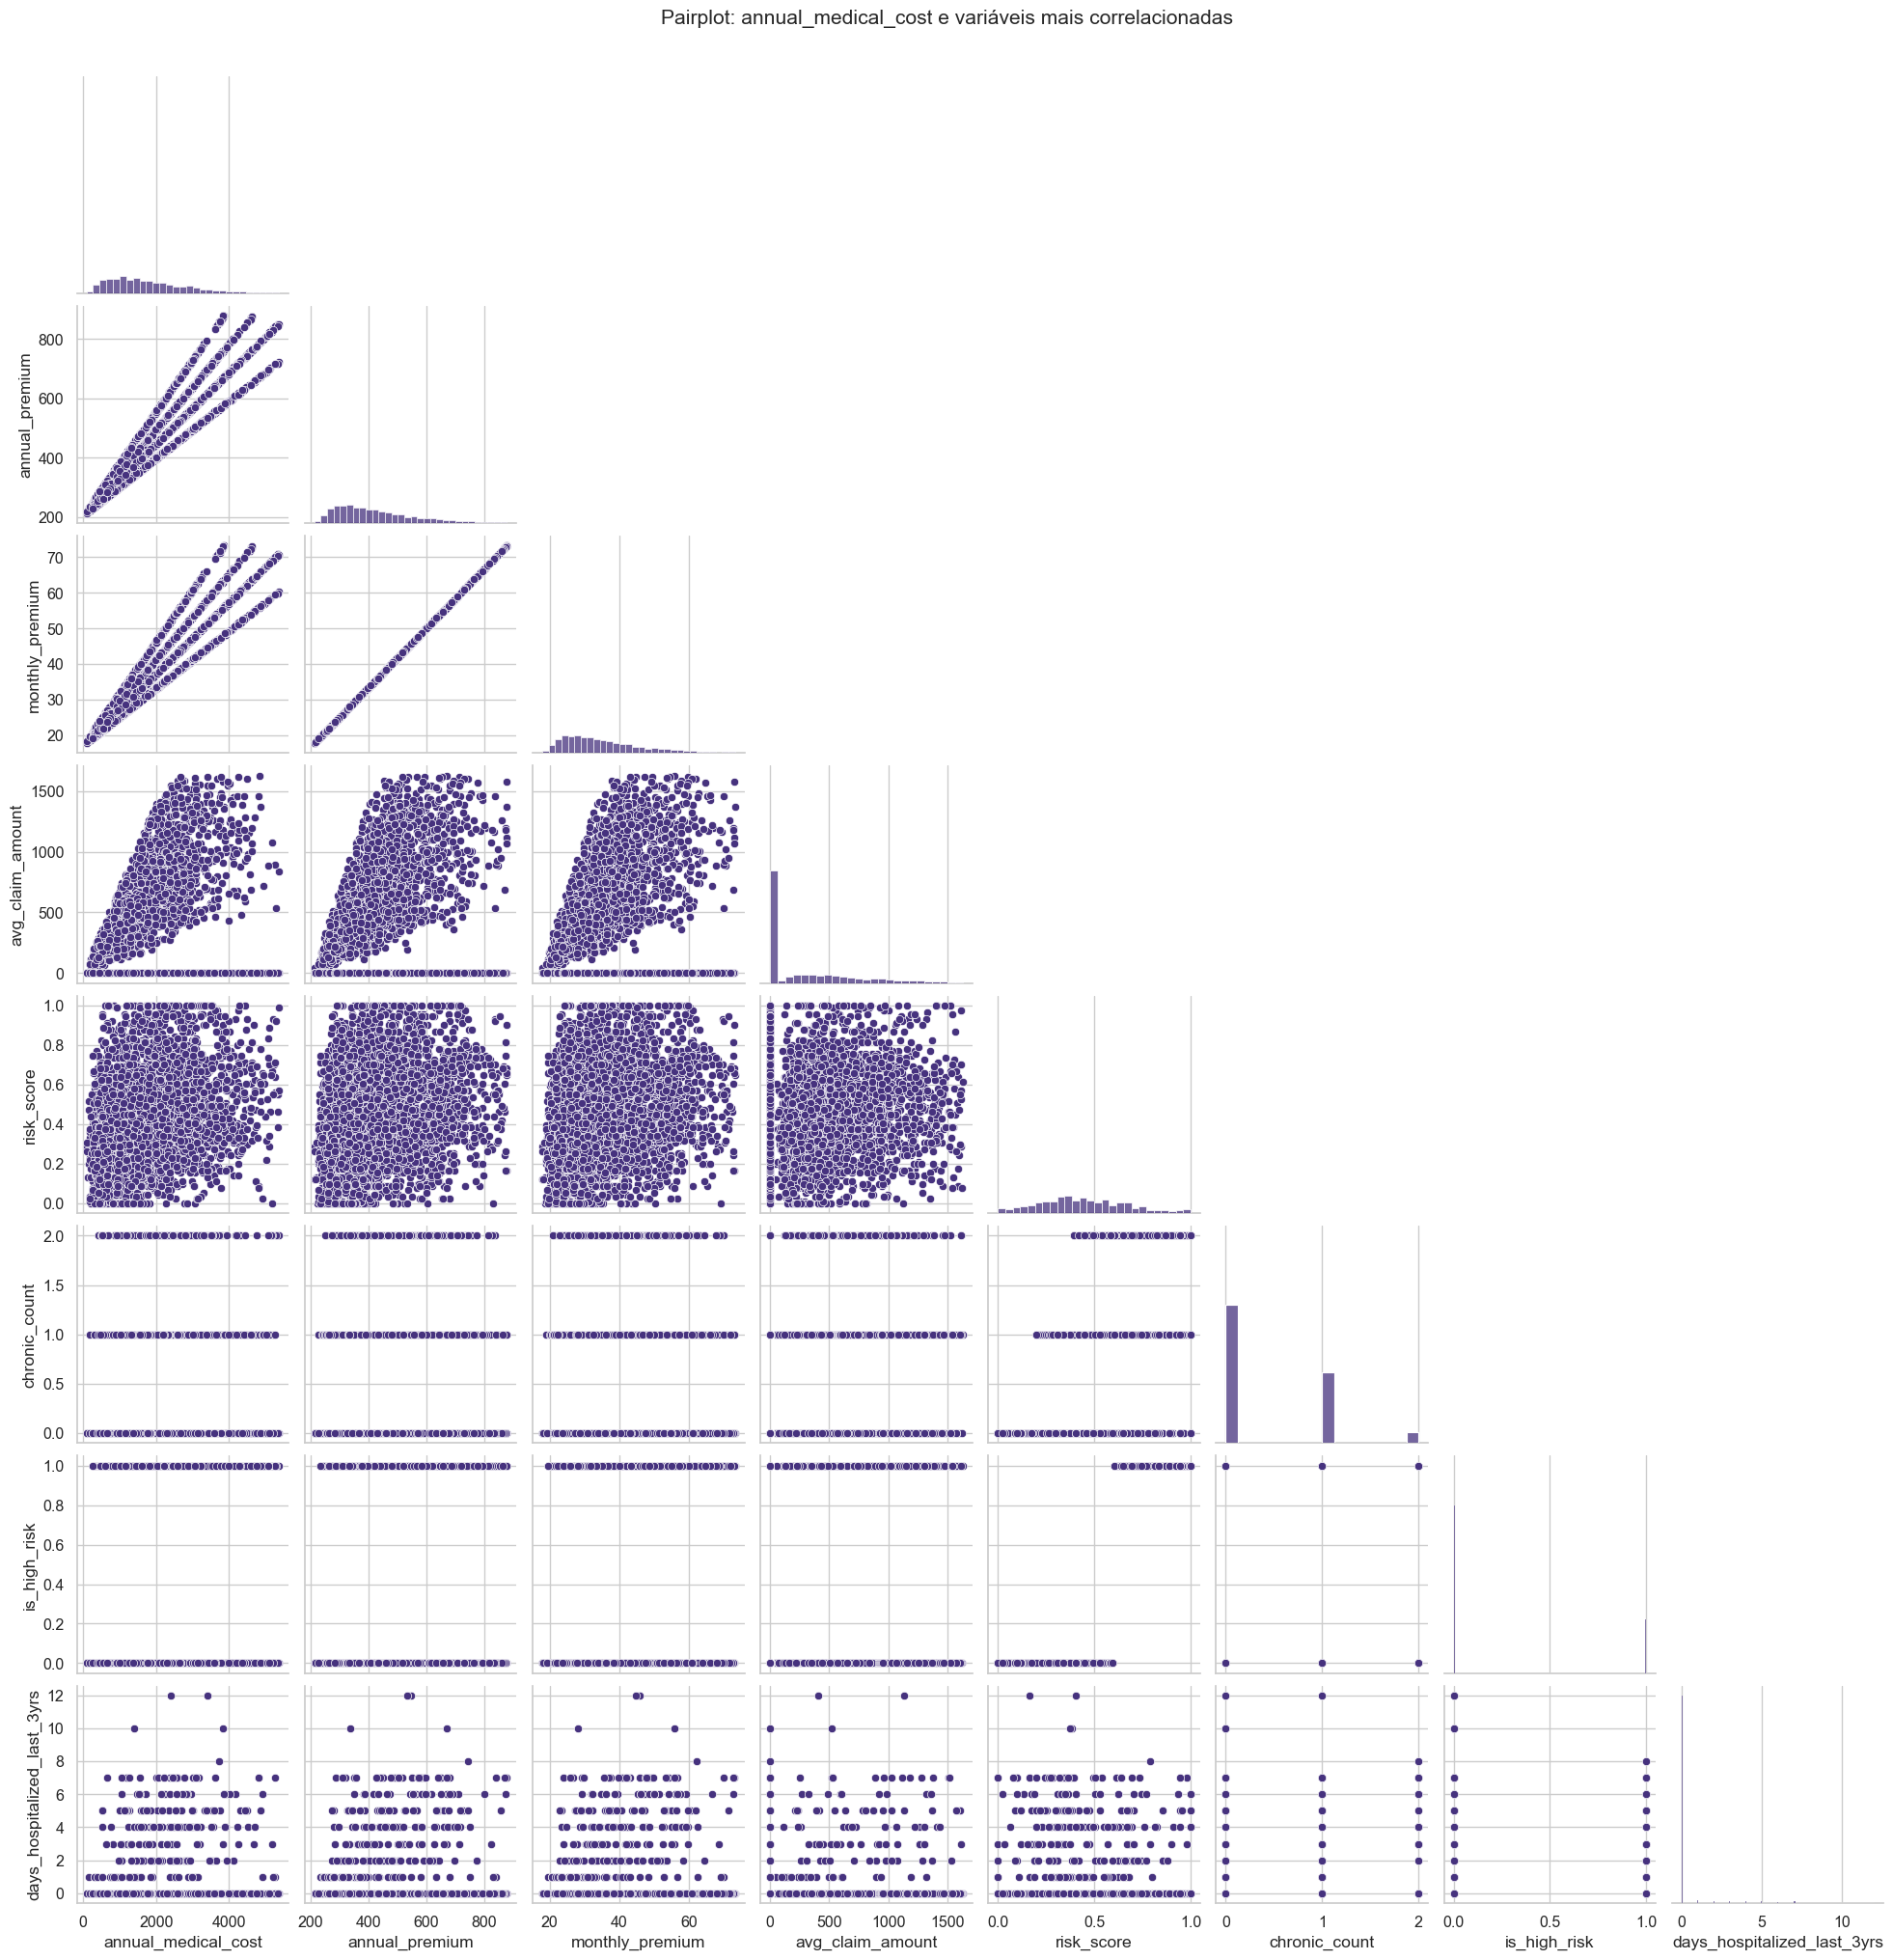

In [101]:

# === 12) Gráficos originais ===
plot_distributions(df, [c for c in num_cols if c != target])
plot_countplots(df, cat_cols, limit_each=40)
plot_boxplots_cat_target(df, cat_cols, target, max_plots=MAX_BOXPLOTS, limit_each=40)
if target:
    plot_scatter_with_target(df, [c for c in num_cols if c != target], target, max_plots=MAX_SCATTERS, sample_n=SAMPLE_FOR_SCATTER)
    plot_pairplot_top(df, target, corr_full, max_vars=MAX_PAIRPLOT_VARS)


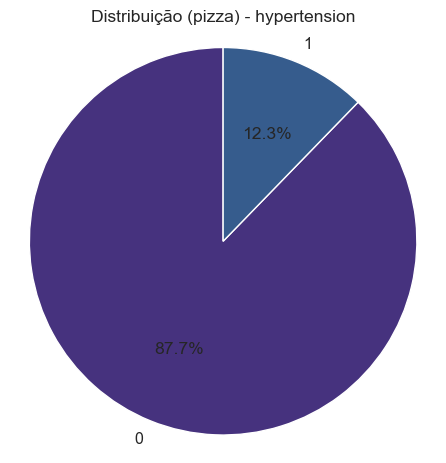

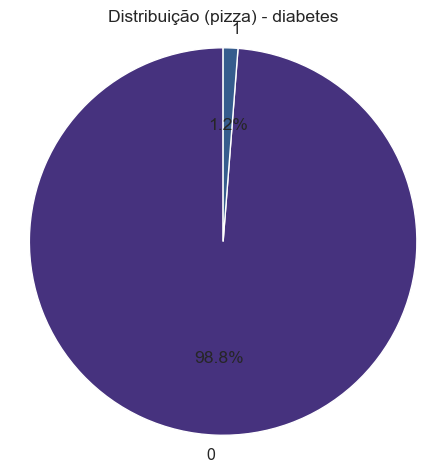

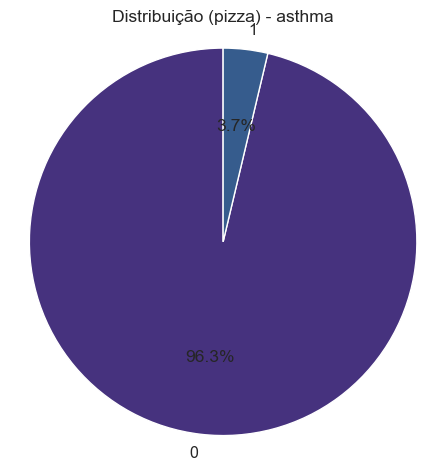

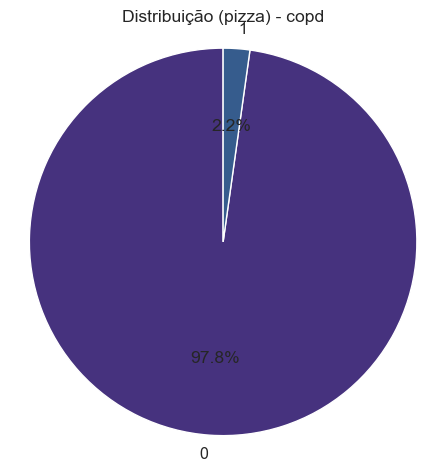

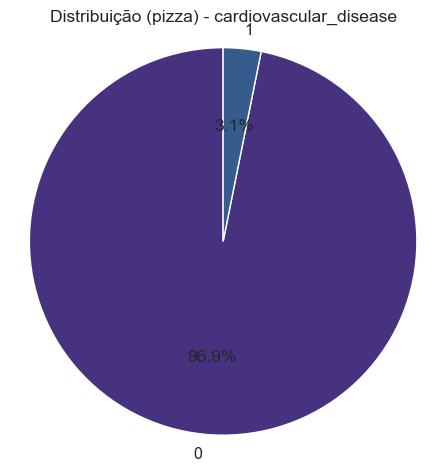

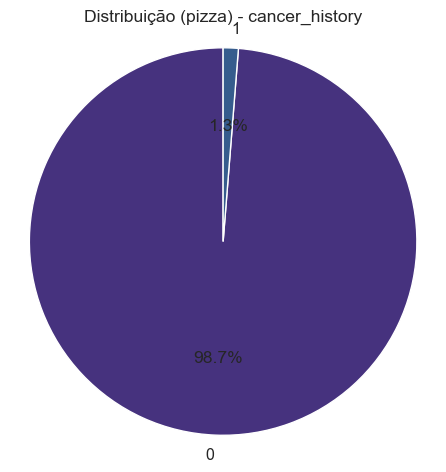

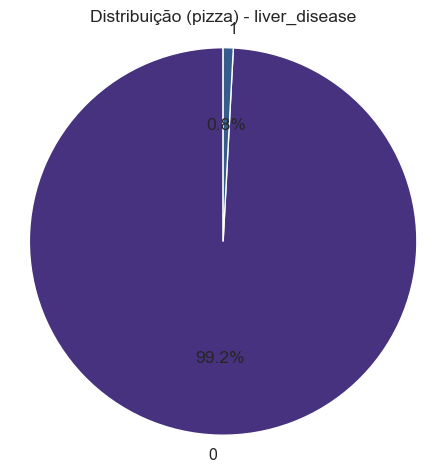

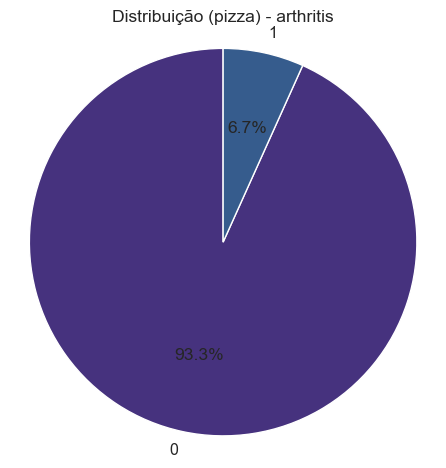

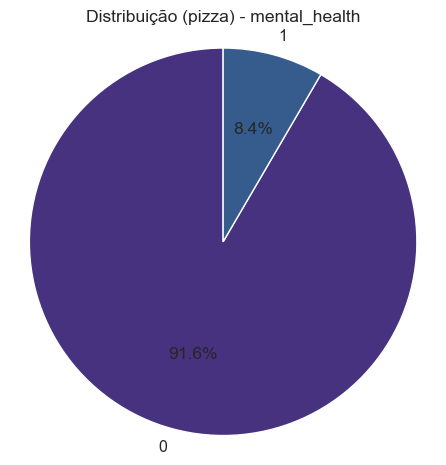

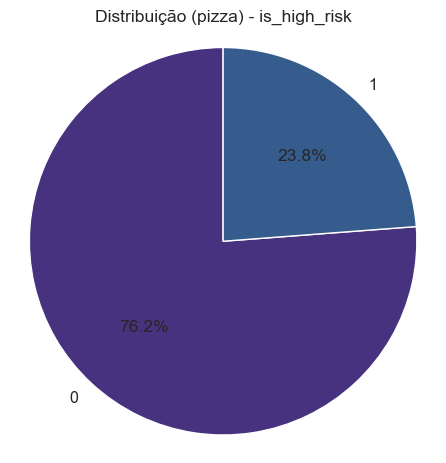

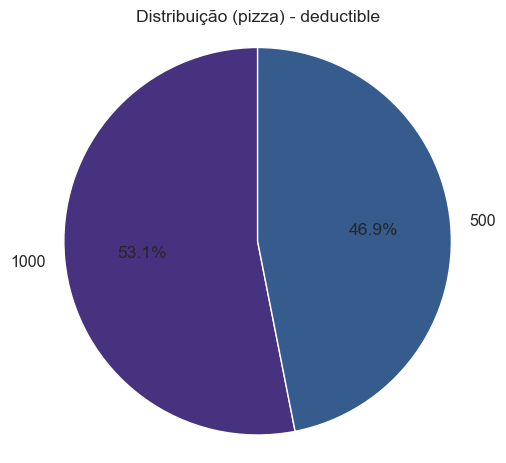

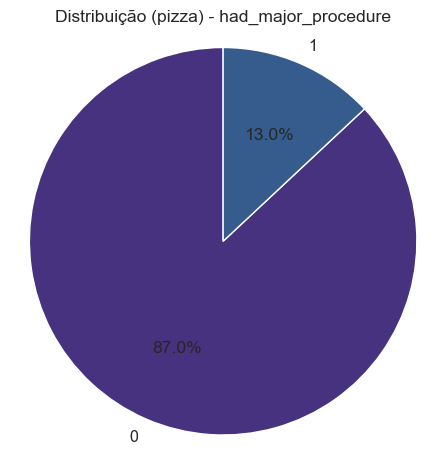

In [102]:

# === 13) Pizzas para todas as binárias ===
if bin_cols:
    plot_pies_for_binary_columns(df, bin_cols, max_pies=MAX_PIES_BINARIES)
else:
    print("[info] Nenhuma coluna binária detectada.")


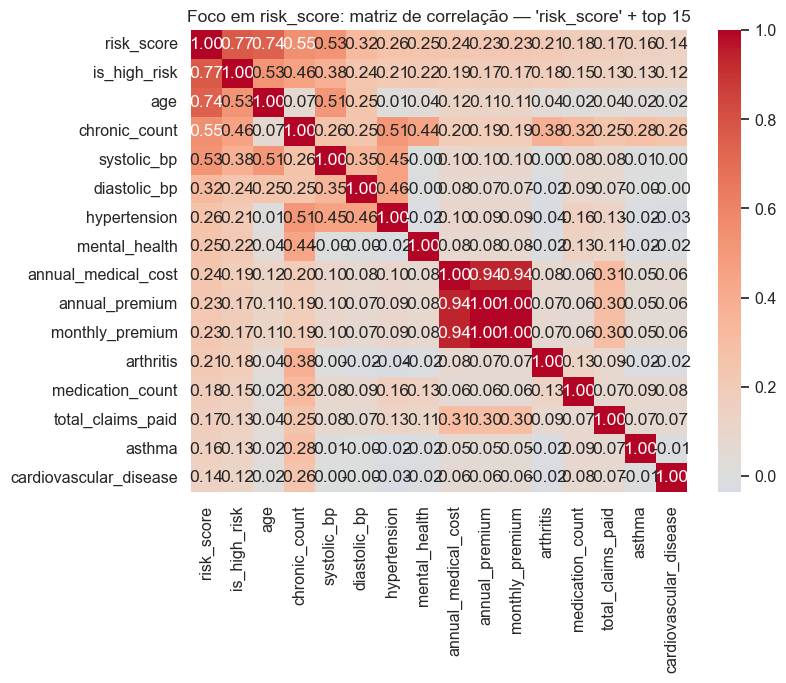

variavel  correlacao  abs_correlacao
0             is_high_risk    0.767057        0.767057
1                      age    0.742219        0.742219
2            chronic_count    0.547287        0.547287
3              systolic_bp    0.527527        0.527527
4             diastolic_bp    0.318584        0.318584
5             hypertension    0.263787        0.263787
6            mental_health    0.251180        0.251180
7      annual_medical_cost    0.240814        0.240814
8           annual_premium    0.230285        0.230285
9          monthly_premium    0.230285        0.230285
10               arthritis    0.214287        0.214287
11        medication_count    0.177897        0.177897
12       total_claims_paid    0.171449        0.171449
13                  asthma    0.156868        0.156868
14  cardiovascular_disease    0.142215        0.142215

[ok] top_corr_with_risk_score.csv salvo.


In [103]:

# === 14) Matriz + Tabela focadas em risk_score ===
tbl_risk, _ = plot_corr_matrix_anchor(df, "risk_score", topn=TOPN_RISK, title_prefix="Foco em risk_score")
if not tbl_risk.empty:
    display(tbl_risk)
    tbl_risk.to_csv("top_corr_with_risk_score.csv", index=False)
    print("[ok] top_corr_with_risk_score.csv salvo.")


variavel  correlacao  abs_correlacao
22              risk_score    0.767057        0.767057
28                     age    0.528588        0.528588
17           chronic_count    0.457966        0.457966
18             systolic_bp    0.379895        0.379895
19            diastolic_bp    0.235110        0.235110
16           mental_health    0.217332        0.217332
7             hypertension    0.209187        0.209187
1      annual_medical_cost    0.186277        0.186277
15               arthritis    0.183887        0.183887
2           annual_premium    0.174397        0.174397
3          monthly_premium    0.174396        0.174396
37        medication_count    0.151449        0.151449
6        total_claims_paid    0.134309        0.134309
9                   asthma    0.128863        0.128863
11  cardiovascular_disease    0.122934        0.122934

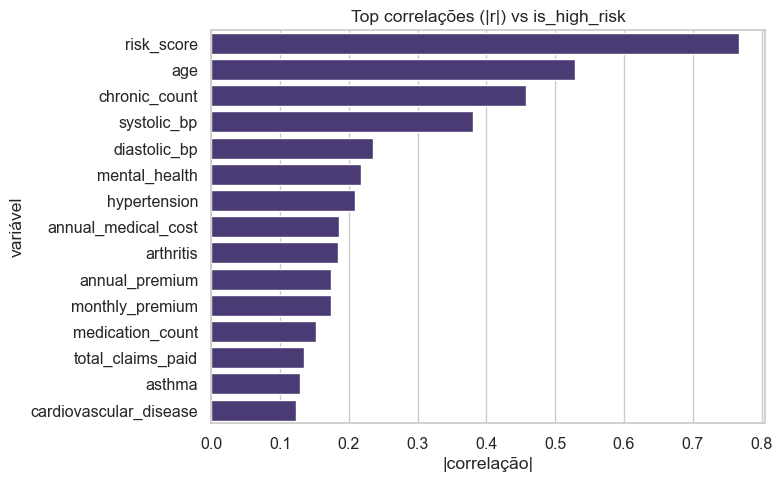

In [104]:

# === 15) Tabela vs is_high_risk (ponto-biserial) + gráfico ===
tbl_is_high = corr_with_binary_anchor(df, "is_high_risk", topn=TOPN_RISK)
if not tbl_is_high.empty:
    display(tbl_is_high)
    tbl_is_high.to_csv("top_corr_with_is_high_risk.csv", index=False)
    plt.figure(figsize=(8,5))
    sns.barplot(data=tbl_is_high, x="abs_correlacao", y="variavel")
    plt.title(tight_title("Top correlações (|r|) vs is_high_risk"))
    plt.xlabel("|correlação|"); plt.ylabel("variável")
    savefig_maybe("top_corr_is_high_risk")
    plt.tight_layout(); plt.show()


[ok] salvo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/notebooks/table_by_risk_bin.csv
[ok] salvo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/notebooks/table_plan_x_risk.csv
[ok] salvo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/notebooks/table_plan_tier_x_risk.csv
[ok] salvo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/notebooks/table_region_x_risk.csv
[ok] salvo: /Users/augusto/Library/Mobile Documents/com~apple~CloudDocs/git/avalensurance-bia/notebooks/table_sex_x_risk.csv

Tabela 'by_risk_bin':


/var/folders/99/0hmnt5l13rn3b4mhfw326ws00000gn/T/ipykernel_6634/3203970203.py:112: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["by_risk_bin"] = (df2.groupby("risk_bin", dropna=True)[cost_col]
/var/folders/99/0hmnt5l13rn3b4mhfw326ws00000gn/T/ipykernel_6634/3203970203.py:116: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  out["plan_x_risk"] = (df2.pivot_table(index=c_plan, columns="risk_bin",
/var/folders/99/0hmnt5l13rn3b4mhfw326ws00000gn/T/ipykernel_6634/3203970203.py:119: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence

risk_bin  count         mean    median          std
0       D1   2158  1364.092141  1150.410   924.158272
1       D2   2269  1532.953098  1315.520   975.455545
2       D3   1922  1598.173465  1350.955  1007.215369
3       D4   1972  1653.497272  1418.695  1040.885475
4       D5   2389  1730.949272  1522.380  1026.722979
5       D6   1855  1801.009208  1565.760  1044.382789
6       D7   2025  1871.899521  1669.580  1064.383502
7       D8   2010  2000.635915  1844.785  1075.154759
8       D9   2172  2095.923720  1903.455  1093.744477
9      D10   1967  2227.657041  2088.710  1109.797064


Tabela 'plan_x_risk':


risk_bin plan_type           D1           D2           D3           D4  \
0              EPO  1352.224452  1458.853223  1543.410189  1695.346740   
1              HMO  1373.681394  1562.969900  1622.183343  1681.145007   
2              NAO  1602.972059  1719.809138  1831.206000  1528.528913   
3              POS  1270.447018  1478.891218  1644.640506  1603.888246   
4              PPO  1381.636735  1538.274138  1566.020264  1637.575043   

risk_bin           D5           D6           D7           D8           D9  \
0         1740.904826  1800.685074  1847.108079  2044.799435  2048.232244   
1         1713.262298  1851.748976  1864.543627  2038.673552  2098.167297   
2         1869.624889  1602.942609  2036.867273  1889.070227  2228.594500   
3         1818.282758  1769.367963  1843.197385  2027.626725  2054.109779   
4         1702.310135  1779.249097  1892.087730  1942.508624  2124.423482   

risk_bin          D10  
0         2364.995203  
1         2236.631439  
2         2269.423438  
3         2130.990912  
4         2202.448670


Tabela 'plan_tier_x_risk':


risk_bin plan_type network_tier           D1           D2           D3  \
0              EPO       Bronze  1525.764896  1442.808737  1544.211205   
1              EPO         Gold  1121.975690  1365.356944  1659.561364   
2              EPO     Platinum  1224.533158  1491.711714  1384.671071   
3              EPO       Silver  1367.692600  1530.630101  1506.049205   
4              HMO       Bronze  1414.000656  1611.946265  1669.762930   
5              HMO         Gold  1298.946107  1581.689664  1634.235077   
6              HMO     Platinum  1317.447200  1455.106883  1441.459756   
7              HMO       Silver  1391.038199  1552.310136  1625.656236   
8              NAO         Gold  1750.227500  1612.676842  1512.370769   
9              NAO     Platinum  1317.518571  1746.047273  1809.525556   
10             NAO       Silver  1646.136842  1782.198214  2165.050769   
11             POS       Bronze  1341.274405  1302.165510  1665.614302   
12             POS         Gold  1412.267674  1459.316038  1373.386458   
13             POS     Platinum   974.542500  1151.955000  1611.760000   
14             POS       Silver  1230.559274  1710.957638  1754.383832   

risk_bin           D4           D5           D6           D7           D8  \
0         1704.094026  1819.749815  1837.399892  1824.884388  2237.932151   
1         1858.099571  1646.969625  1781.213478  1782.047727  1816.772456   
2         1460.250606  1438.812571  1832.475385  1669.002667  1646.431034   
3         1649.023441  1820.018760  1766.191190  1956.506852  2108.154038   
4         1654.415735  1694.677149  1952.084574  1864.925373  2107.944515   
5         1515.357040  1672.993274  1880.793284  1981.319065  1982.865177   
6         1625.051600  1508.663553  1681.764348  1806.044800  1811.792500   
7         1752.716397  1784.623284  1777.458774  1841.339962  2091.517165   
8         1874.960833  1532.748125  1752.522500  1941.628889  2020.673333   
9         1517.535000  1510.344286  1320.816250  2013.086667  1848.798571   
10        1382.413929  2228.942727  1596.748636  2081.080952  1812.154545   
11        1546.515065  1874.371743  1828.332222  1985.099770  2238.559500   
12        1349.641163  1739.662449  1526.602222  1558.867632  1865.354490   
13        1392.584000  1665.390000  1664.507692  1696.221613  1875.331765   
14        1756.829219  1827.797095  1845.918807  1872.190385  1938.195169   

risk_bin           D9          D10  
0         2163.996216  2437.989000  
1         2268.833279  2567.983158  
2         1929.663571  2034.105769  
3         1842.995268  2267.682653  
4         2053.849576  2324.401667  
5         2080.702742  2292.002857  
6         2004.607531  2009.768310  
7         2163.793883  2221.749743  
8         2135.399000  2296.295714  
9         2802.020000  2049.666000  
10        2176.219615  2314.957500  
11        1902.192165  2146.053500  
12        2355.705098  2212.819792  
13        1680.647037  1676.899630  
14        2120.575563  2193.049273


Tabela 'region_x_risk':


risk_bin   region           D1           D2           D3           D4  \
0         Central  1486.029458  1692.345036  1547.362549  1632.543870   
1            East  1450.305653  1491.005819  1615.554973  1581.500202   
2           North  1331.474816  1493.273809  1601.624568  1703.620255   
3           South  1348.556882  1538.783239  1613.606325  1619.200476   
4            West  1237.919490  1510.794940  1579.187237  1738.565670   

risk_bin           D5           D6           D7           D8           D9  \
0         1852.444829  1787.066579  1803.406056  2057.958095  2041.751691   
1         1725.685890  1740.543033  1867.542389  2005.441049  2082.731445   
2         1720.614665  1815.653000  1864.764681  1999.706303  2247.687547   
3         1725.064547  1756.487862  1850.366605  1958.450000  2044.088789   
4         1684.250520  1943.494013  1970.274533  2029.241070  2039.988684   

risk_bin          D10  
0         2132.742532  
1         2177.246163  
2         2293.552743  
3         2256.458764  
4         2222.614526


Tabela 'sex_x_risk':


risk_bin     sex           D1           D2           D3           D4  \
0         Female  1348.792138  1530.175344  1607.545410  1642.436545   
1           Male  1368.865071  1544.126306  1574.074698  1640.464736   

risk_bin           D5           D6           D7           D8           D9  \
0         1722.718726  1783.654683  1846.854402  1947.352581  2127.517009   
1         1751.353583  1814.749705  1912.547717  2068.040053  2088.573318   

risk_bin          D10  
0         2243.582393  
1         2206.659565

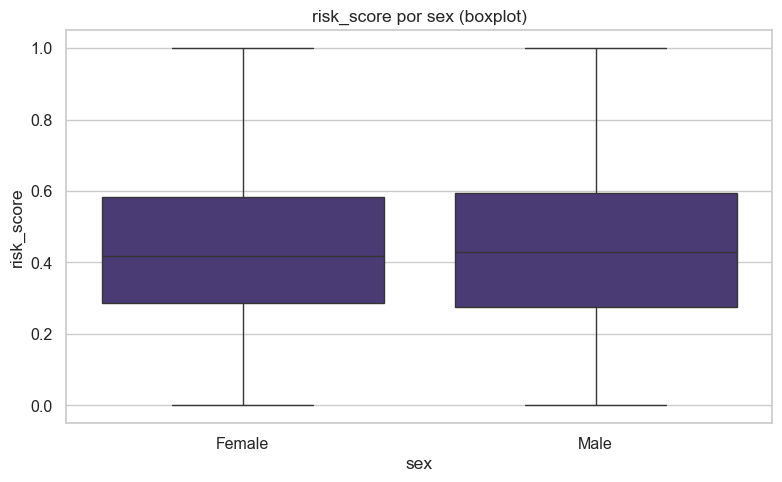

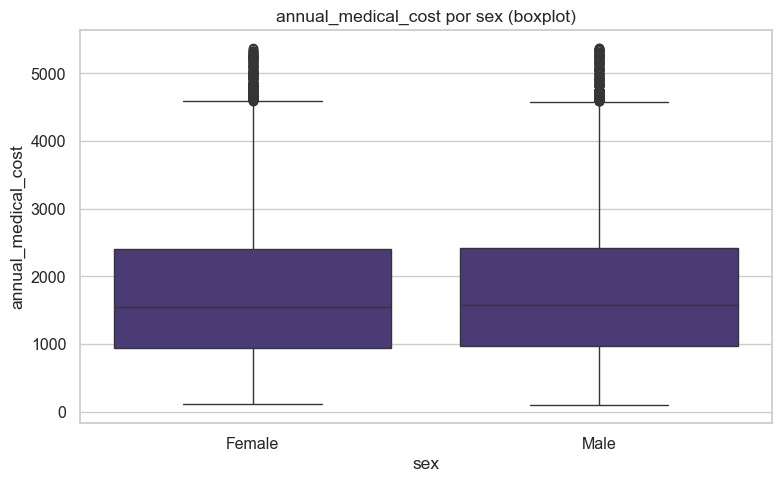

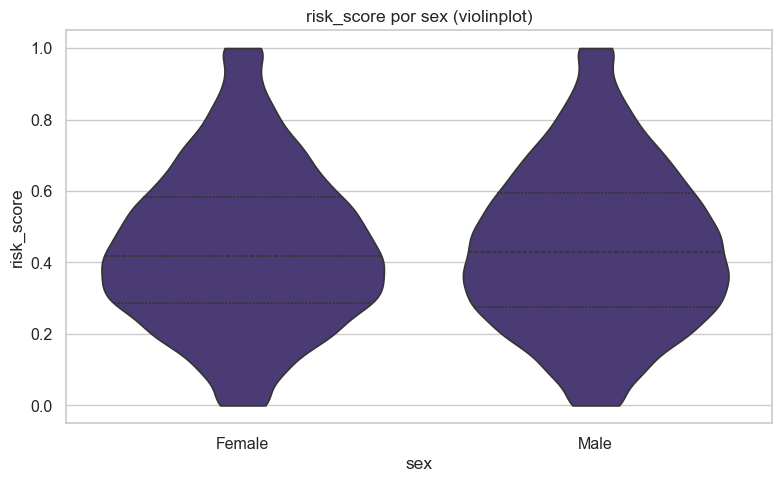

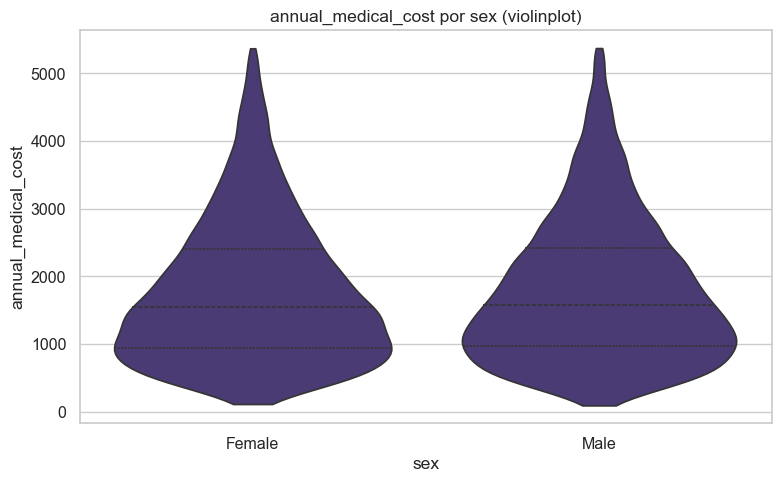

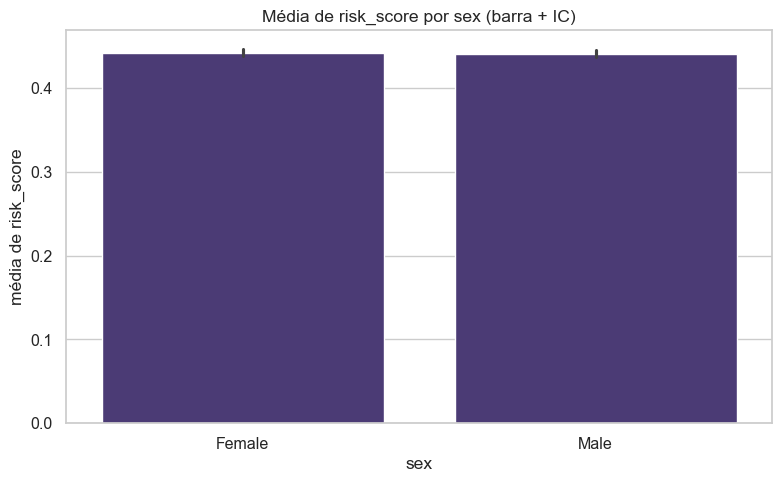

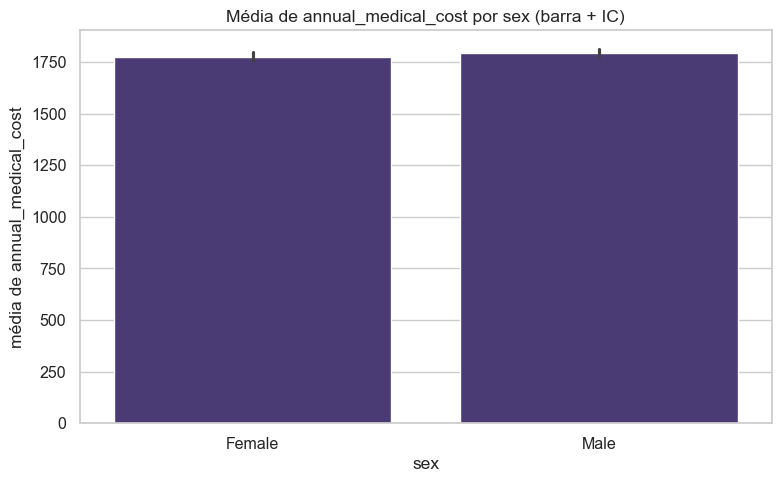

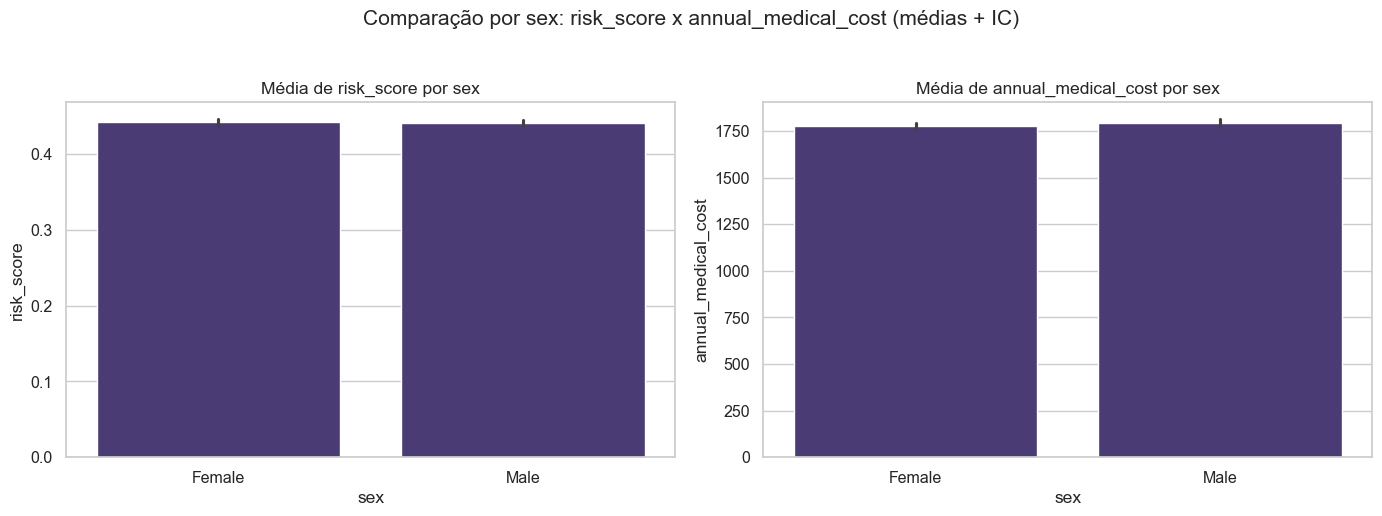

In [105]:

# === 16) Tabelas multivariáveis (annual_medical_cost × risk_score × categorias) ===
mv = multivar_tables(df, cost_col="annual_medical_cost", risk_col="risk_score")
for k, v in mv.items():
    print(f"\nTabela '{k}':")
    display(v.head(15))
  # === 17) Comparações por sexo (Male, Female, no_data) ===
plot_sex_risk_cost_comparisons(
    df,
    sex_col="sex",
    risk_col="risk_score",
    cost_col="annual_medical_cost"
)


## 17) Encerramento
CSVs gerados (quando aplicáveis):

- `top_corr_with_risk_score.csv`
- `top_corr_with_is_high_risk.csv`
- `table_by_risk_bin.csv`, `table_plan_x_risk.csv`, `table_plan_tier_x_risk.csv`, `table_region_x_risk.csv`, `table_sex_x_risk.csv`

Ajuste `CSV_PATH`, `SAVE_FIGS` e limites (`MAX_*`) conforme a necessidade.
